# Flood Prediction Model using Support Vector Machines (XGBOOST)

This notebook will consist of the Following:


Preprocessing 
1. DEM
2. Flood Maps
3. Soil
4. Rainfall Hytograph

Feature Engineering
1. Building of maps 
2. Normalization
3. Resizing
4. Converting to NumPy Tensors

Model Building 
1. XGBOOST initialization
2. Training
3. Evaluation

# Auxiliary Map 

## Preprocessing

In [10]:
import os

repo_root = os.getcwd()

fm_path = os.path.join(repo_root, "flood_maps")
dem_path = os.path.join(repo_root, "dem")
drainage_path = os.path.join(repo_root, "drainage")
soil_path = os.path.join(repo_root, "soil_types")
tidal_path = os.path.join(repo_root, "tidal")
building_path = os.path.join(repo_root, "building_footprint")

## Ground truth 

### Medium 

Found 5 flood maps: ['D:\\PC\\Documents\\SCHOOL\\GIT-THESIS\\XGBOOST-CONF\\flood_maps\\Medium_Scenario\\AL_M_Chicago_10.tif', 'D:\\PC\\Documents\\SCHOOL\\GIT-THESIS\\XGBOOST-CONF\\flood_maps\\Medium_Scenario\\AL_M_Chicago_15.tif', 'D:\\PC\\Documents\\SCHOOL\\GIT-THESIS\\XGBOOST-CONF\\flood_maps\\Medium_Scenario\\AL_M_Chicago_30.tif', 'D:\\PC\\Documents\\SCHOOL\\GIT-THESIS\\XGBOOST-CONF\\flood_maps\\Medium_Scenario\\AL_M_Chicago_5.tif', 'D:\\PC\\Documents\\SCHOOL\\GIT-THESIS\\XGBOOST-CONF\\flood_maps\\Medium_Scenario\\AL_M_Chicago_60.tif']
Saving classified map to: processed_aux_map\ground_truth\M_Chicago_Water_Pixel.tif


C:\Users\PC\AppData\Local\Temp\ipykernel_7280\3331051363.py:43: RuntimeWarning: Mean of empty slice
  avg_flood = np.nanmean(arrays, axis=0)


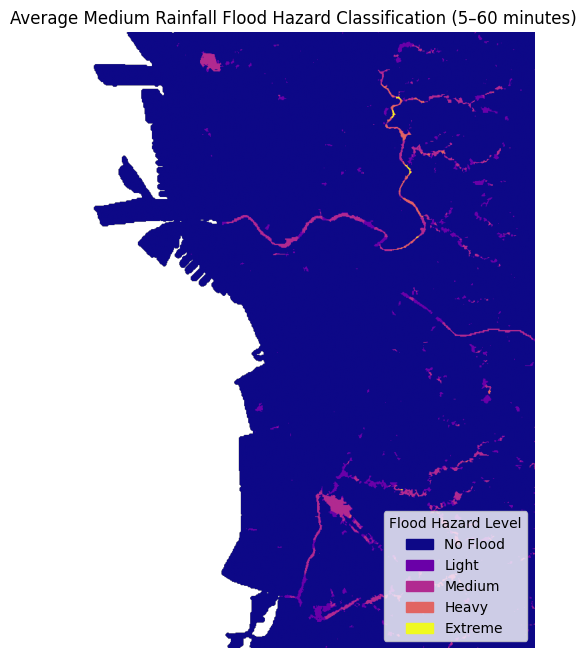

In [18]:
import os
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches


# Folder containing flood map TIFF files
input_folder = "D:\\PC\\Documents\\SCHOOL\\GIT-THESIS\\XGBOOST-CONF\\flood_maps\\Medium_Scenario"
output_dir = os.path.join("processed_aux_map", "ground_truth")
output_filename = "M_Chicago_Water_Pixel.tif" # <--- Saved filename for Medium
output_path = os.path.join(output_dir, output_filename)

# Automatically list all .tif files in the folder
tif_files = [os.path.join(input_folder, f) for f in os.listdir(input_folder) if f.endswith(".tif")]

if not tif_files:
    raise FileNotFoundError("No .tif files found in the 'floodmaps' folder.")

print(f"Found {len(tif_files)} flood maps:", tif_files)


arrays = []
masks = []

for f in tif_files:
    with rasterio.open(f) as src:
        data = src.read(1)
        nodata = src.nodata

        # Create a mask for valid (non-nodata) pixels
        mask = np.ones_like(data, dtype=bool)
        if nodata is not None:
            mask = data != nodata
            data = np.where(mask, data, np.nan)  # replace nodata with NaN for averaging

        arrays.append(data)
        masks.append(mask)
        profile = src.profile

# Compute average flood depth (ignoring NaN)
avg_flood = np.nanmean(arrays, axis=0)

# --- CLASSIFICATION BASED ON DEPTH ---
flood_class = np.full_like(avg_flood, fill_value=-1, dtype=np.int8)  # start with -1 (no data)

valid_mask = ~np.isnan(avg_flood)  # valid (land) pixels

# Apply classification only to valid pixels
flood_class[(avg_flood >= 0.00) & (avg_flood <= 0.32) & valid_mask] = 0
flood_class[(avg_flood > 0.32) & (avg_flood <= 0.48) & valid_mask] = 1
flood_class[(avg_flood > 0.48) & (avg_flood <= 0.97) & valid_mask] = 2
flood_class[(avg_flood > 0.97) & (avg_flood <= 1.46) & valid_mask] = 3
flood_class[(avg_flood > 1.46) & valid_mask] = 4

# Update metadata (keep nodata value)
os.makedirs(output_dir, exist_ok=True)

# Update metadata (Set dtype to int8 and nodata to -1)
profile.update(count=1, dtype=rasterio.int8, nodata=-1)

print(f"Saving classified map to: {output_path}")
with rasterio.open(output_path, "w", **profile) as dst:
    dst.write(flood_class, 1)

# --- CUSTOM CATEGORICAL COLORMAP ---
hazard_colors = [
    "#0d0887",  # 0 - No Flood (light green)
    "#6a00a8",  # 1 - Light (beige/orange)
    "#b12a90",  # 2 - Medium (pink/purple)
    "#e16462",  # 3 - Heavy (light blue)
    "#f0f921"   # 4 - Extreme (red/orange)
]
hazard_labels = ["No Flood", "Light", "Medium", "Heavy", "Extreme"]
cmap = ListedColormap(hazard_colors)

# Plot only valid land areas
plt.figure(figsize=(10, 8))
im = plt.imshow(np.ma.masked_where(flood_class == -1, flood_class), cmap=cmap)
plt.title("Average Medium Rainfall Flood Hazard Classification (5–60 minutes)")
plt.axis("off")

# Legend
patches = [mpatches.Patch(color=hazard_colors[i], label=hazard_labels[i]) for i in range(len(hazard_labels))]
plt.legend(handles=patches, loc="lower right", title="Flood Hazard Level", frameon=True)

plt.show()


### Light

Found 5 flood maps: ['D:\\PC\\Documents\\SCHOOL\\GIT-THESIS\\XGBOOST-CONF\\flood_maps\\Light_Scenario\\CA_L_CHICAGO_10.tif', 'D:\\PC\\Documents\\SCHOOL\\GIT-THESIS\\XGBOOST-CONF\\flood_maps\\Light_Scenario\\CA_L_CHICAGO_15.tif', 'D:\\PC\\Documents\\SCHOOL\\GIT-THESIS\\XGBOOST-CONF\\flood_maps\\Light_Scenario\\CA_L_CHICAGO_30.tif', 'D:\\PC\\Documents\\SCHOOL\\GIT-THESIS\\XGBOOST-CONF\\flood_maps\\Light_Scenario\\CA_L_CHICAGO_5.tif', 'D:\\PC\\Documents\\SCHOOL\\GIT-THESIS\\XGBOOST-CONF\\flood_maps\\Light_Scenario\\CA_L_CHICAGO_60.tif']
Saving classified map to: processed_aux_map\ground_truth\L_Chicago_Water_Pixel.tif


C:\Users\PC\AppData\Local\Temp\ipykernel_7280\2255042903.py:44: RuntimeWarning: Mean of empty slice
  avg_flood = np.nanmean(arrays, axis=0)


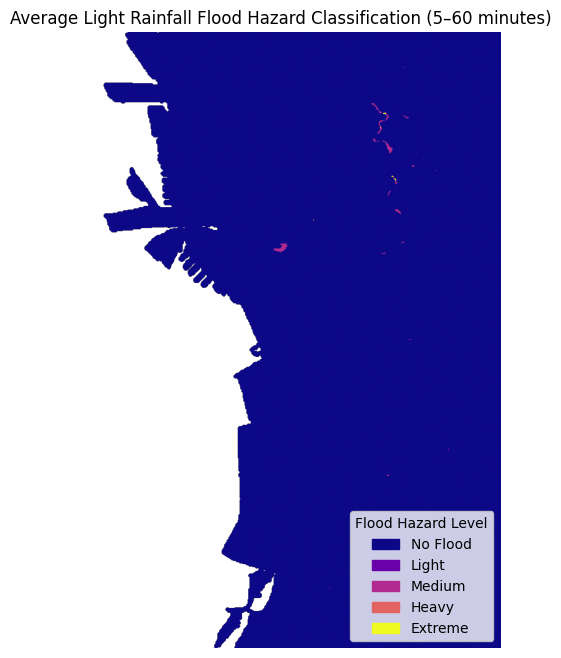

In [19]:
import os
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches


# Folder containing flood map TIFF files
input_folder = "D:\\PC\\Documents\\SCHOOL\\GIT-THESIS\\XGBOOST-CONF\\flood_maps\\Light_Scenario"
# Define Output Directory
output_dir = os.path.join("processed_aux_map", "ground_truth")
output_filename = "L_Chicago_Water_Pixel.tif" # <--- Saved filename for Light
output_path = os.path.join(output_dir, output_filename)

# Automatically list all .tif files in the folder
tif_files = [os.path.join(input_folder, f) for f in os.listdir(input_folder) if f.endswith(".tif")]

if not tif_files:
    raise FileNotFoundError("No .tif files found in the 'floodmaps' folder.")

print(f"Found {len(tif_files)} flood maps:", tif_files)


arrays = []
masks = []

for f in tif_files:
    with rasterio.open(f) as src:
        data = src.read(1)
        nodata = src.nodata

        # Create a mask for valid (non-nodata) pixels
        mask = np.ones_like(data, dtype=bool)
        if nodata is not None:
            mask = data != nodata
            data = np.where(mask, data, np.nan)  # replace nodata with NaN for averaging

        arrays.append(data)
        masks.append(mask)
        profile = src.profile

# Compute average flood depth (ignoring NaN)
avg_flood = np.nanmean(arrays, axis=0)

# --- CLASSIFICATION BASED ON DEPTH ---
flood_class = np.full_like(avg_flood, fill_value=-1, dtype=np.int8)  # start with -1 (no data)

valid_mask = ~np.isnan(avg_flood)  # valid (land) pixels

# Apply classification only to valid pixels
flood_class[(avg_flood >= 0.00) & (avg_flood <= 0.32) & valid_mask] = 0
flood_class[(avg_flood > 0.32) & (avg_flood <= 0.48) & valid_mask] = 1
flood_class[(avg_flood > 0.48) & (avg_flood <= 0.97) & valid_mask] = 2
flood_class[(avg_flood > 0.97) & (avg_flood <= 1.46) & valid_mask] = 3
flood_class[(avg_flood > 1.46) & valid_mask] = 4

# Update metadata (keep nodata value)
os.makedirs(output_dir, exist_ok=True)

# Update metadata (Set dtype to int8 and nodata to -1)
profile.update(count=1, dtype=rasterio.int8, nodata=-1)

print(f"Saving classified map to: {output_path}")
with rasterio.open(output_path, "w", **profile) as dst:
    dst.write(flood_class, 1)

# --- CUSTOM CATEGORICAL COLORMAP ---
hazard_colors = [
    "#0d0887",  # 0 - No Flood (light green)
    "#6a00a8",  # 1 - Light (beige/orange)
    "#b12a90",  # 2 - Medium (pink/purple)
    "#e16462",  # 3 - Heavy (light blue)
    "#f0f921"   # 4 - Extreme (red/orange)
]
hazard_labels = ["No Flood", "Light", "Medium", "Heavy", "Extreme"]
cmap = ListedColormap(hazard_colors)

# Plot only valid land areas
plt.figure(figsize=(10, 8))
im = plt.imshow(np.ma.masked_where(flood_class == -1, flood_class), cmap=cmap)
plt.title("Average Light Rainfall Flood Hazard Classification (5–60 minutes)")
plt.axis("off")

# Legend
patches = [mpatches.Patch(color=hazard_colors[i], label=hazard_labels[i]) for i in range(len(hazard_labels))]
plt.legend(handles=patches, loc="lower right", title="Flood Hazard Level", frameon=True)

plt.show()


### Heavy

Found 5 flood maps: ['D:\\PC\\Documents\\SCHOOL\\GIT-THESIS\\XGBOOST-CONF\\flood_maps\\Heavy_Scenario\\CK_H_Chicago_10.tif', 'D:\\PC\\Documents\\SCHOOL\\GIT-THESIS\\XGBOOST-CONF\\flood_maps\\Heavy_Scenario\\CK_H_Chicago_15.tif', 'D:\\PC\\Documents\\SCHOOL\\GIT-THESIS\\XGBOOST-CONF\\flood_maps\\Heavy_Scenario\\CK_H_Chicago_30.tif', 'D:\\PC\\Documents\\SCHOOL\\GIT-THESIS\\XGBOOST-CONF\\flood_maps\\Heavy_Scenario\\CK_H_Chicago_5.tif', 'D:\\PC\\Documents\\SCHOOL\\GIT-THESIS\\XGBOOST-CONF\\flood_maps\\Heavy_Scenario\\CK_H_Chicago_60.tif']
Saving classified map to: processed_aux_map\ground_truth\H_Chicago_Water_Pixel.tif


C:\Users\PC\AppData\Local\Temp\ipykernel_7280\3201478319.py:44: RuntimeWarning: Mean of empty slice
  avg_flood = np.nanmean(arrays, axis=0)


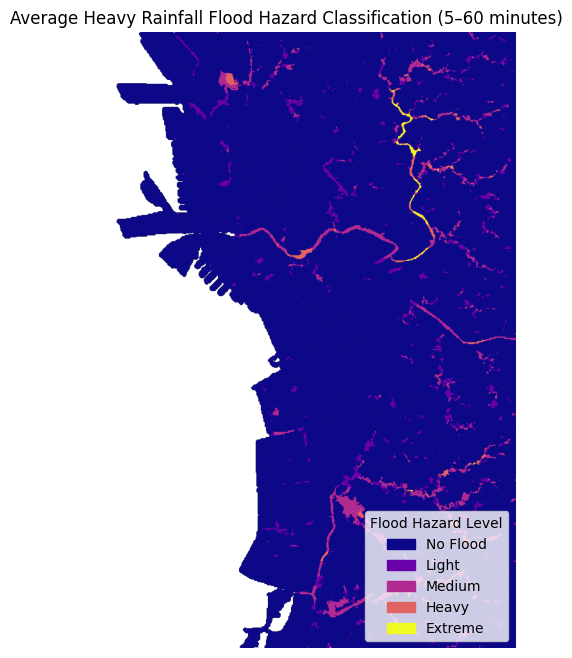

In [22]:
import os
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches


# Folder containing flood map TIFF files
input_folder = "D:\\PC\\Documents\\SCHOOL\\GIT-THESIS\\XGBOOST-CONF\\flood_maps\\Heavy_Scenario"
# Define Output Directory
output_dir = os.path.join("processed_aux_map", "ground_truth")
output_filename = "H_Chicago_Water_Pixel.tif" 
output_path = os.path.join(output_dir, output_filename)

# Automatically list all .tif files in the folder
tif_files = [os.path.join(input_folder, f) for f in os.listdir(input_folder) if f.endswith(".tif")]

if not tif_files:
    raise FileNotFoundError("No .tif files found in the 'floodmaps' folder.")

print(f"Found {len(tif_files)} flood maps:", tif_files)


arrays = []
masks = []

for f in tif_files:
    with rasterio.open(f) as src:
        data = src.read(1)
        nodata = src.nodata

        # Create a mask for valid (non-nodata) pixels
        mask = np.ones_like(data, dtype=bool)
        if nodata is not None:
            mask = data != nodata
            data = np.where(mask, data, np.nan)  # replace nodata with NaN for averaging

        arrays.append(data)
        masks.append(mask)
        profile = src.profile

# Compute average flood depth (ignoring NaN)
avg_flood = np.nanmean(arrays, axis=0)

# --- CLASSIFICATION BASED ON DEPTH ---
flood_class = np.full_like(avg_flood, fill_value=-1, dtype=np.int8)  # start with -1 (no data)

valid_mask = ~np.isnan(avg_flood)  # valid (land) pixels

# Apply classification only to valid pixels
flood_class[(avg_flood >= 0.00) & (avg_flood <= 0.32) & valid_mask] = 0
flood_class[(avg_flood > 0.32) & (avg_flood <= 0.48) & valid_mask] = 1
flood_class[(avg_flood > 0.48) & (avg_flood <= 0.97) & valid_mask] = 2
flood_class[(avg_flood > 0.97) & (avg_flood <= 1.46) & valid_mask] = 3
flood_class[(avg_flood > 1.46) & valid_mask] = 4

# Update metadata (keep nodata value)
os.makedirs(output_dir, exist_ok=True)

# Update metadata (Set dtype to int8 and nodata to -1)
profile.update(count=1, dtype=rasterio.int8, nodata=-1)

print(f"Saving classified map to: {output_path}")
with rasterio.open(output_path, "w", **profile) as dst:
    dst.write(flood_class, 1)

# --- CUSTOM CATEGORICAL COLORMAP ---
hazard_colors = [
    "#0d0887",  # 0 - No Flood (light green)
    "#6a00a8",  # 1 - Light (beige/orange)
    "#b12a90",  # 2 - Medium (pink/purple)
    "#e16462",  # 3 - Heavy (light blue)
    "#f0f921"   # 4 - Extreme (red/orange)
]
hazard_labels = ["No Flood", "Light", "Medium", "Heavy", "Extreme"]
cmap = ListedColormap(hazard_colors)

# Plot only valid land areas
plt.figure(figsize=(10, 8))
im = plt.imshow(np.ma.masked_where(flood_class == -1, flood_class), cmap=cmap)
plt.title("Average Heavy Rainfall Flood Hazard Classification (5–60 minutes)")
plt.axis("off")

# Legend
patches = [mpatches.Patch(color=hazard_colors[i], label=hazard_labels[i]) for i in range(len(hazard_labels))]
plt.legend(handles=patches, loc="lower right", title="Flood Hazard Level", frameon=True)

plt.show()


### Extreme

Found 5 flood maps: ['D:\\PC\\Documents\\SCHOOL\\GIT-THESIS\\XGBOOST-CONF\\flood_maps\\Extreme_Scenario\\MK_E_Chicago_10.tif', 'D:\\PC\\Documents\\SCHOOL\\GIT-THESIS\\XGBOOST-CONF\\flood_maps\\Extreme_Scenario\\MK_E_Chicago_15.tif', 'D:\\PC\\Documents\\SCHOOL\\GIT-THESIS\\XGBOOST-CONF\\flood_maps\\Extreme_Scenario\\MK_E_Chicago_30.tif', 'D:\\PC\\Documents\\SCHOOL\\GIT-THESIS\\XGBOOST-CONF\\flood_maps\\Extreme_Scenario\\MK_E_Chicago_5.tif', 'D:\\PC\\Documents\\SCHOOL\\GIT-THESIS\\XGBOOST-CONF\\flood_maps\\Extreme_Scenario\\MK_E_Chicago_60.tif']
Saving classified map to: processed_aux_map\ground_truth\E_Chicago_Water_Pixel.tif


C:\Users\PC\AppData\Local\Temp\ipykernel_7280\3055115418.py:42: RuntimeWarning: Mean of empty slice
  avg_flood = np.nanmean(arrays, axis=0)


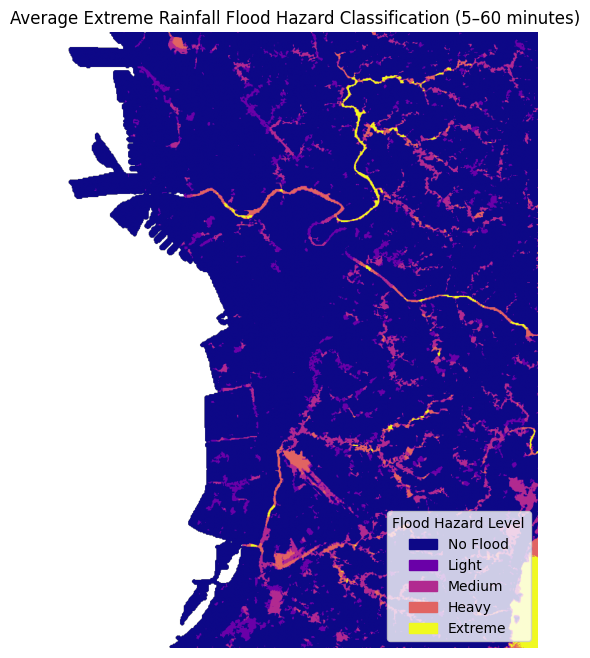

In [23]:
import os
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches


# Folder containing flood map TIFF files
input_folder = "D:\\PC\\Documents\\SCHOOL\\GIT-THESIS\\XGBOOST-CONF\\flood_maps\\Extreme_Scenario"
output_dir = os.path.join("processed_aux_map", "ground_truth")
output_filename = "E_Chicago_Water_Pixel.tif" # <--- Saved filename for Extreme
output_path = os.path.join(output_dir, output_filename)
# Automatically list all .tif files in the folder
tif_files = [os.path.join(input_folder, f) for f in os.listdir(input_folder) if f.endswith(".tif")]

if not tif_files:
    raise FileNotFoundError("No .tif files found in the 'floodmaps' folder.")

print(f"Found {len(tif_files)} flood maps:", tif_files)


arrays = []
masks = []

for f in tif_files:
    with rasterio.open(f) as src:
        data = src.read(1)
        nodata = src.nodata

        # Create a mask for valid (non-nodata) pixels
        mask = np.ones_like(data, dtype=bool)
        if nodata is not None:
            mask = data != nodata
            data = np.where(mask, data, np.nan)  # replace nodata with NaN for averaging

        arrays.append(data)
        masks.append(mask)
        profile = src.profile

# Compute average flood depth (ignoring NaN)
avg_flood = np.nanmean(arrays, axis=0)

# --- CLASSIFICATION BASED ON DEPTH ---
flood_class = np.full_like(avg_flood, fill_value=-1, dtype=np.int8)  # start with -1 (no data)

valid_mask = ~np.isnan(avg_flood)  # valid (land) pixels

# Apply classification only to valid pixels
flood_class[(avg_flood >= 0.00) & (avg_flood <= 0.32) & valid_mask] = 0
flood_class[(avg_flood > 0.32) & (avg_flood <= 0.48) & valid_mask] = 1
flood_class[(avg_flood > 0.48) & (avg_flood <= 0.97) & valid_mask] = 2
flood_class[(avg_flood > 0.97) & (avg_flood <= 1.46) & valid_mask] = 3
flood_class[(avg_flood > 1.46) & valid_mask] = 4

# Update metadata (keep nodata value)
os.makedirs(output_dir, exist_ok=True)

# Update metadata (Set dtype to int8 and nodata to -1)
profile.update(count=1, dtype=rasterio.int8, nodata=-1)

print(f"Saving classified map to: {output_path}")
with rasterio.open(output_path, "w", **profile) as dst:
    dst.write(flood_class, 1)

# --- CUSTOM CATEGORICAL COLORMAP ---
hazard_colors = [
    "#0d0887",  # 0 - No Flood (light green)
    "#6a00a8",  # 1 - Light (beige/orange)
    "#b12a90",  # 2 - Medium (pink/purple)
    "#e16462",  # 3 - Heavy (light blue)
    "#f0f921"   # 4 - Extreme (red/orange)
]
hazard_labels = ["No Flood", "Light", "Medium", "Heavy", "Extreme"]
cmap = ListedColormap(hazard_colors)

# Plot only valid land areas
plt.figure(figsize=(10, 8))
im = plt.imshow(np.ma.masked_where(flood_class == -1, flood_class), cmap=cmap)
plt.title("Average Extreme Rainfall Flood Hazard Classification (5–60 minutes)")
plt.axis("off")

# Legend
patches = [mpatches.Patch(color=hazard_colors[i], label=hazard_labels[i]) for i in range(len(hazard_labels))]
plt.legend(handles=patches, loc="lower right", title="Flood Hazard Level", frameon=True)

plt.show()


## DEM

Processing DEM: D:\PC\Documents\SCHOOL\GIT-THESIS\XGBOOST-CONF\dem\manila_clipped_DEM.tif
DEM Resized to: (256, 256)
Saved DEM Stack: (3, 256, 256) to ./processed_aux_map/processed_dem_numpy\dem_features.npy


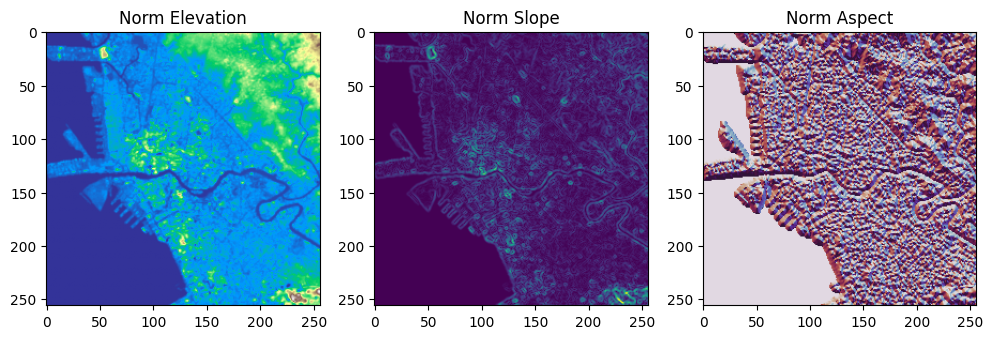

In [ ]:
import os
import numpy as np
import rasterio
from rasterio.enums import Resampling
import matplotlib.pyplot as plt

#paths
dem_path = "D:\\PC\\Documents\\SCHOOL\\GIT-THESIS\\XGBOOST-CONF\\dem\\manila_clipped_DEM.tif" 
H_target, W_target = 256, 256     
save_dir = "./processed_aux_map/processed_dem_numpy"

# LOAD AND RESIZE DEM
print(f"Processing DEM: {dem_path}")
with rasterio.open(dem_path) as src:
    dem_arr = src.read(
        1,
        out_shape=(H_target, W_target),
        resampling=Resampling.bilinear
    )
    
    # Update metadata 
    dem_transform = src.transform * src.transform.scale(
        (src.width / W_target),
        (src.height / H_target)
    )

# float32 and handle NODATA
dem_arr = dem_arr.astype(np.float32)
# If DEM has -9999 or nodata:
dem_arr[dem_arr < -1000] = np.nan 
dem_arr = np.nan_to_num(dem_arr, nan=np.nanmin(dem_arr))

print(f"DEM Resized to: {dem_arr.shape}")

# SLOPE & ASPECT assumes pixels are roughly square in meters. 
#dy, dx = np.gradient(dem_arr)
res_x = abs(dem_transform.a)
res_y = abs(dem_transform.e)
dy, dx = np.gradient(dem_arr, res_y, res_x)

# Slope
slope_rad = np.arctan(np.sqrt(dx**2 + dy**2))
slope_deg = np.degrees(slope_rad)

# Aspect 
aspect_rad = np.arctan2(-dx, dy)
aspect_deg = np.degrees(aspect_rad)
aspect_deg = np.where(aspect_deg < 0, aspect_deg + 360, aspect_deg) 

# normalize
def min_max_norm(arr):
    mn, mx = np.nanmin(arr), np.nanmax(arr)
    if mx - mn == 0: return np.zeros_like(arr)
    return (arr - mn) / (mx - mn)

dem_norm = min_max_norm(dem_arr)
slope_norm = min_max_norm(slope_deg)
aspect_norm = min_max_norm(aspect_deg)

# stack and save
dem_stack = np.stack([dem_norm, slope_norm, aspect_norm], axis=0)

os.makedirs(save_dir, exist_ok=True)
save_path = os.path.join(save_dir, "dem_features.npy")
np.save(save_path, dem_stack)
print(f"Saved DEM Stack: {dem_stack.shape} to {save_path}")

# Visualization
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
ax[0].imshow(dem_norm, cmap='terrain'); ax[0].set_title("Norm Elevation")
ax[1].imshow(slope_norm, cmap='viridis'); ax[1].set_title("Norm Slope")
ax[2].imshow(aspect_norm, cmap='twilight'); ax[2].set_title("Norm Aspect")
plt.show()

## soil types

In [ ]:
import os
import glob
import numpy as np
import rasterio
from rasterio.enums import Resampling

# paths
soil_path = "D:\\PC\\Documents\\SCHOOL\\GIT-THESIS\\XGBOOST-CONF\\soil_types"
H_target, W_target = 256, 256   

# Find files
all_tifs = glob.glob(os.path.join(soil_path, "*.tif"))
soil_files = [f for f in all_tifs if not f.endswith(".aux.xml")]

print(f"Found {len(soil_files)} soil files.")

print("Soil files:", soil_files)

# ---------------------------
# PER-LAYER NORMALIZATION ONLY
# ---------------------------
processed_layers = []
filenames_processed = []

for f in soil_files:
    with rasterio.open(f) as src:
        arr = src.read(
            1,
            out_shape=(H_target, W_target),
            resampling=Resampling.bilinear
        ).astype(np.float32)
    
    # Treat invalid values as NaN
    arr[arr < -1000] = np.nan

    # Compute per-layer min/max
    layer_min = np.nanmin(arr)
    layer_max = np.nanmax(arr)

    print("\n=== Normalization for:", os.path.basename(f), "===")
    print("  Layer Min:", layer_min)
    print("  Layer Max:", layer_max)
    print("  Range:", layer_max - layer_min)

    # Replace NaNs with min
    arr = np.nan_to_num(arr, nan=layer_min)

    # PER-LAYER NORMALIZATION
    if layer_max - layer_min > 0:
        norm_arr = (arr - layer_min) / (layer_max - layer_min)
    else:
        norm_arr = np.zeros_like(arr)

    processed_layers.append(norm_arr)
    filenames_processed.append(os.path.basename(f))

    print(f"Processed (per-layer normalized): {os.path.basename(f)}")

# Stack -> Shape (N_layers, H, W)
soil_stack = np.stack(processed_layers, axis=0)

# Save
save_dir_soil = "./processed_aux_map/processed_soil_numpy"
os.makedirs(save_dir_soil, exist_ok=True)
save_path_soil = os.path.join(save_dir_soil, "soil_features.npy")

np.save(save_path_soil, soil_stack)

print("\nFinal Stack Shape:", soil_stack.shape)
print("Order:", filenames_processed)
print("Saved to:", save_path_soil)


Found 4 soil files.
Soil files: ['D:\\PC\\Documents\\SCHOOL\\GIT-THESIS\\XGBOOST-CONF\\soil_types\\Clay_Content_Percent_Manila.tif', 'D:\\PC\\Documents\\SCHOOL\\GIT-THESIS\\XGBOOST-CONF\\soil_types\\Organic_Carbon_Content_Manila.tif', 'D:\\PC\\Documents\\SCHOOL\\GIT-THESIS\\XGBOOST-CONF\\soil_types\\Sand_Content_Percent_Manila.tif', 'D:\\PC\\Documents\\SCHOOL\\GIT-THESIS\\XGBOOST-CONF\\soil_types\\Soil_pH_H2O_Manila.tif']

=== Normalization for: Clay_Content_Percent_Manila.tif ===
  Layer Min: 0.0
  Layer Max: 40.0
  Range: 40.0
Processed (per-layer normalized): Clay_Content_Percent_Manila.tif

=== Normalization for: Organic_Carbon_Content_Manila.tif ===
  Layer Min: 0.0
  Layer Max: 33.0
  Range: 33.0
Processed (per-layer normalized): Organic_Carbon_Content_Manila.tif

=== Normalization for: Sand_Content_Percent_Manila.tif ===
  Layer Min: 0.0
  Layer Max: 47.0
  Range: 47.0
Processed (per-layer normalized): Sand_Content_Percent_Manila.tif

=== Normalization for: Soil_pH_H2O_Manila.ti

Loaded Soil Stack. Shape: (4, 256, 256)
   (Channels, Height, Width)


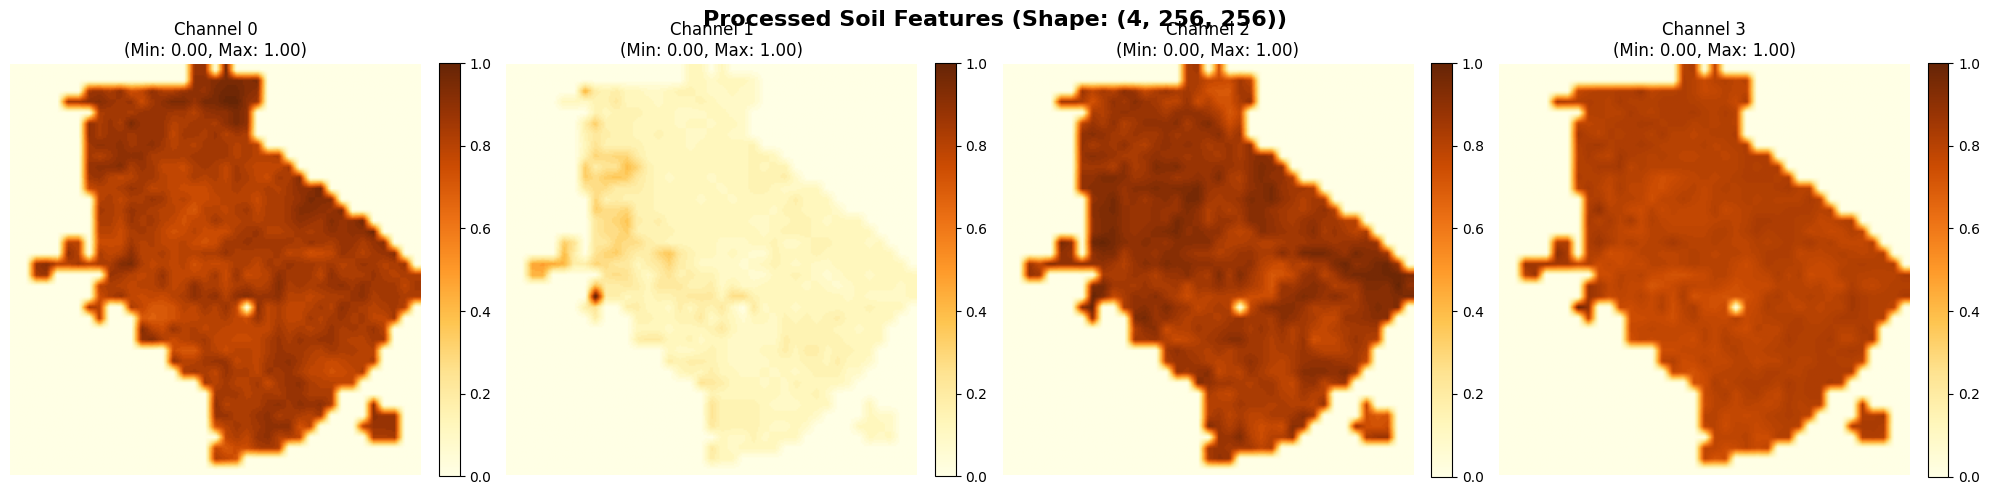

In [80]:
import numpy as np
import matplotlib.pyplot as plt
import os

load_path = "./processed_aux_map/processed_soil_numpy/soil_features.npy"

# Check if file exists
if not os.path.exists(load_path):
    print(f"File not found at: {load_path}")
else:
    #Load Data
    soil_stack = np.load(load_path)
    print(f"Loaded Soil Stack. Shape: {soil_stack.shape}")
    print(f"   (Channels, Height, Width)")

    # Setup Plotting
    num_channels = soil_stack.shape[0]
    
    # Create subplots (1 row, N columns)
    fig, axes = plt.subplots(1, num_channels, figsize=(5 * num_channels, 5))

    #Loop through channels and display
    for i, ax in enumerate(axes):
        layer = soil_stack[i]
        
        # Display image
        im = ax.imshow(layer, cmap='YlOrBr', vmin=0, vmax=1) 
        # Style
        ax.set_title(f"Channel {i}\n(Min: {layer.min():.2f}, Max: {layer.max():.2f})")
        ax.axis('off') 
        # Add colorbar for reference
        plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

    plt.suptitle(f"Processed Soil Features (Shape: {soil_stack.shape})", fontsize=16, weight='bold')
    plt.tight_layout()
    plt.show()

## Rainfall Hyetograph Integration

In [10]:
import os
import pandas as pd
import numpy as np

# CONFIG
repo_root = "D:\\PC\\Documents\\SCHOOL\\GIT-THESIS\\XGBOOST-CONF"
hyeto_dir = os.path.join(repo_root, "chicago-hyetograph")

save_dir = os.path.join(repo_root, "processed_aux_map", "hyetograph")
os.makedirs(save_dir, exist_ok=True)

scenarios = ["light", "medium", "heavy", "extreme"]

def load_chicago_hyetographs_numpy(hyetograph_dir):
    hyeto_data = {}

    for sc in scenarios:
        # Construct filename: e.g., "Light_summary.csv"
        file_path = os.path.join(hyetograph_dir, f"{sc.capitalize()}_summary.csv")
        
        if not os.path.exists(file_path):
            raise FileNotFoundError(f"Missing file for {sc}: {file_path}")

        df = pd.read_csv(file_path)
        
        # Normalize columns to ensure we find 'chicago'
        df.columns = [c.lower().strip() for c in df.columns]

        if "chicago" not in df.columns:
            raise ValueError(f"'chicago' column not found in {file_path}")

        # Extract first 5 values
        chicago_vals = df["chicago"].iloc[:5].to_numpy()

        # Convert to float32
        hyeto_array = chicago_vals.astype(np.float32)
        hyeto_data[sc.upper()] = hyeto_array

        # --- Save each scenario as NumPy file ---
        save_path = os.path.join(save_dir, f"{sc.upper()}_chicago.npy")
        np.save(save_path, hyeto_array)
        print(f"Saved {sc.upper()} hyetograph to {save_path}")

    return hyeto_data

# Load and save hyetographs
try:
    chicago_hyetographs = load_chicago_hyetographs_numpy(hyeto_dir)

    print("\nLoaded Chicago Hyetographs (as NumPy arrays):")
    for k, v in chicago_hyetographs.items():
        print(f"{k}: {v} | shape={v.shape} | dtype={v.dtype}")

except Exception as e:
    print(f"Error: {e}")


Saved LIGHT hyetograph to D:\PC\Documents\SCHOOL\GIT-THESIS\XGBOOST-CONF\processed_aux_map\hyetograph\LIGHT_chicago.npy
Saved MEDIUM hyetograph to D:\PC\Documents\SCHOOL\GIT-THESIS\XGBOOST-CONF\processed_aux_map\hyetograph\MEDIUM_chicago.npy
Saved HEAVY hyetograph to D:\PC\Documents\SCHOOL\GIT-THESIS\XGBOOST-CONF\processed_aux_map\hyetograph\HEAVY_chicago.npy
Saved EXTREME hyetograph to D:\PC\Documents\SCHOOL\GIT-THESIS\XGBOOST-CONF\processed_aux_map\hyetograph\EXTREME_chicago.npy

Loaded Chicago Hyetographs (as NumPy arrays):
LIGHT: [5.19 5.1  4.96 4.32 2.62] | shape=(5,) | dtype=float32
MEDIUM: [38.06 37.9  36.46 30.58 16.77] | shape=(5,) | dtype=float32
HEAVY: [95.82 89.29 78.1  49.05 24.74] | shape=(5,) | dtype=float32
EXTREME: [142.34 129.67 115.55  72.04  36.49] | shape=(5,) | dtype=float32


## Land use

Processing Land Use Map: D:\PC\Documents\SCHOOL\GIT-THESIS\XGBOOST-CONF\land_use\landuse_masked.tif
Land Use Map Clipped and Resized to: (256, 256)
Saved Clipped Land Use Stack: (1, 256, 256) to ./processed_aux_map/processed_landuse_numpy\landuse_features.npy


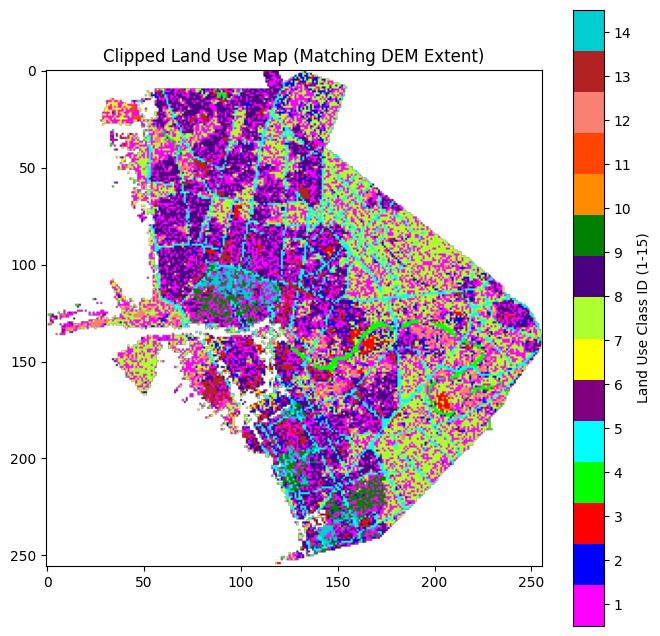

In [1]:
import os
import numpy as np
import rasterio
from rasterio.enums import Resampling
from rasterio.warp import reproject
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap 

def process_clip_color_and_save_landuse(
    landuse_path: str, 
    dem_clip_path: str, 
    h_target: int, 
    w_target: int, 
    save_dir: str
):
    """
    Loads, clips, resizes, colors, and saves the reclassified land use map 
    as a NumPy tensor, matching the DEM's extent using reproject.
    """
    
    # --- 1. Define Custom Colormap (from previous step) ---
    colors = [
        '#FF00FF', '#0000FF', '#FF0000', '#00FF00', '#00FFFF', '#800080', 
        '#FFFF00', '#ADFF2F', '#4B0082', '#008000', '#FF8C00', '#FF4500', 
        '#FA8072', '#B22222', '#00CED1'
    ]
    custom_cmap = ListedColormap(colors)

    print(f"Processing Land Use Map: {landuse_path}")
    
    try:
        # --- 2. Load DEM to get its Spatial Context (CRS, Transform, NoData) ---
        with rasterio.open(dem_clip_path) as src_dem:
            dem_profile = src_dem.profile
            dem_crs = src_dem.crs
            dem_nodata = dem_profile.get('nodata', None)
            
            target_width = w_target
            target_height = h_target
            
            # Calculate the target transform (used for the output)
            target_transform = src_dem.transform * src_dem.transform.scale(
                (src_dem.width / target_width),
                (src_dem.height / target_height)
            )
            
            # Load DEM data to create the valid mask
            dem_data_check = src_dem.read(
                1,
                out_shape=(target_height, target_width),
                resampling=Resampling.bilinear
            )
            
            # Create a mask where DEM data is valid
            if dem_nodata is not None:
                valid_dem_mask = (dem_data_check != dem_nodata)
            else: 
                valid_dem_mask = (dem_data_check > -9999) # Fallback for common elevation nodata
            
        # --- 3. Load Land Use and Reproject/Resample to Target ---
        with rasterio.open(landuse_path) as src_lu:
            # --- FIX 1: Access the source band's data type directly ---
            src_dtype = src_lu.dtypes[0] # Access dtype from the list of dtypes
            lu_nodata = src_lu.profile.get('nodata', 0)
            
            # Initialize the output array with the correct dtype
            clipped_landuse_arr = np.empty((target_height, target_width), dtype=src_dtype)
            
            # 💡 Reproject to handle the geometric transformation
            reproject(
                # Source needs to be specified as a band
                source=rasterio.band(src_lu, 1), 
                destination=clipped_landuse_arr,
                src_transform=src_lu.transform,
                src_crs=src_lu.crs,
                dst_transform=target_transform,
                dst_crs=dem_crs,
                resampling=Resampling.nearest,
                num_threads=4 
                # src_dtype is not passed as an explicit argument, but inferred from source
            )

        # --- 4. Final Clipping/Masking (Applying DEM's footprint) ---
        output_nodata_val = 0 # Assuming 0 is not a valid class ID (1-15)
        
        final_landuse_arr = clipped_landuse_arr
        
        # Apply the mask: set areas outside the valid DEM footprint to nodata (0)
        final_landuse_arr[~valid_dem_mask] = output_nodata_val
        
        # Ensure any original land use nodata values are also set to 0
        final_landuse_arr[final_landuse_arr == lu_nodata] = output_nodata_val
        
        # Cast to float32 for ML consistency
        final_landuse_arr = final_landuse_arr.astype(np.float32)

        print(f"Land Use Map Clipped and Resized to: {final_landuse_arr.shape}")
        
        # --- 5. Stack and Save as NumPy Tensor ---
        landuse_stack = np.stack([final_landuse_arr], axis=0) 

        os.makedirs(save_dir, exist_ok=True)
        save_path = os.path.join(save_dir, "landuse_features.npy")
        np.save(save_path, landuse_stack)
        
        print(f"Saved Clipped Land Use Stack: {landuse_stack.shape} to {save_path}")

        # --- 6. Visualization with Custom Colors ---
        plt.figure(figsize=(8, 8))
        clipped_landuse_display = np.copy(final_landuse_arr)
        # Set 0 (nodata) to NaN so matplotlib handles it as transparent/background
        clipped_landuse_display[clipped_landuse_display == output_nodata_val] = np.nan
        
        img = plt.imshow(clipped_landuse_display, cmap=custom_cmap, vmin=1, vmax=15)
        
        cbar = plt.colorbar(img, ticks=np.arange(1, 16) + 0.5) 
        cbar.set_ticklabels(np.arange(1, 16))
        cbar.set_label("Land Use Class ID (1-15)")
        
        plt.title("Clipped Land Use Map (Matching DEM Extent)")
        plt.show()

    except rasterio.RasterioIOError as e:
        print(f"❌ ERROR: Could not open a file. Check paths and permissions: {e}")
    except Exception as e:
        print(f"❌ An unexpected error occurred: {e}")

# --- EXECUTION ---
LANDUSE_PATH = r"D:\PC\Documents\SCHOOL\GIT-THESIS\XGBOOST-CONF\land_use\landuse_masked.tif"
DEM_CLIP_PATH = r"D:\PC\Documents\SCHOOL\GIT-THESIS\XGBOOST-CONF\dem\manila_clipped_DEM.tif" 
H_target, W_target = 256, 256     
SAVE_DIR = r"./processed_aux_map/processed_landuse_numpy" 

# Run the processing function
process_clip_color_and_save_landuse(
    landuse_path=LANDUSE_PATH,
    dem_clip_path=DEM_CLIP_PATH,
    h_target=H_target,
    w_target=W_target,
    save_dir=SAVE_DIR
)

# GET IT READY FOR XGBOOST

### Mask

   -> Coordinates look like Lat/Lon. Setting to EPSG:4326 (WGS 84).
   Reference DEM Shape: (492, 486) (Should be 256x256 for your pipeline)
Reprojecting shapefile to match DEM (EPSG:3857)...
Rasterizing (Converting Vector to Pixels)...
✅ TIF saved: D:\PC\Documents\SCHOOL\GIT-THESIS\XGBOOST-CONF\manila_mask.tif
NPY saved: D:\PC\Documents\SCHOOL\GIT-THESIS\XGBOOST-CONF\manila_mask.npy
Valid Pixels: 138765


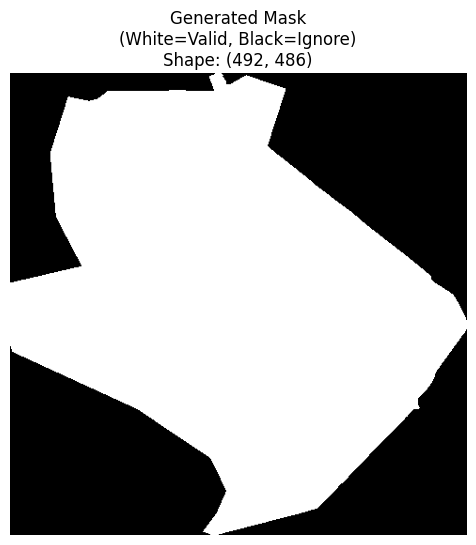

In [13]:
import geopandas as gpd
import rasterio
from rasterio.features import rasterize
import matplotlib.pyplot as plt
import numpy as np
import os

shapefile_path = "D:\\PC\\Documents\\SCHOOL\\GIT-THESIS\\XGBOOST-CONF\\manila-shape\\manila-shapefile.shp"
reference_dem_path = "D:\\PC\\Documents\\SCHOOL\\GIT-THESIS\\XGBOOST-CONF\\dem\\manila_clipped_DEM.tif"
output_tif_path = "D:\\PC\\Documents\\SCHOOL\\GIT-THESIS\\XGBOOST-CONF\\manila_mask.tif"
output_npy_path = "D:\\PC\\Documents\\SCHOOL\\GIT-THESIS\\XGBOOST-CONF\\manila_mask.npy" 


# laoad shapefile
if not os.path.exists(shapefile_path):
    raise FileNotFoundError(f"Shapefile not found at: {shapefile_path}")

gdf = gpd.read_file(shapefile_path)

# Handle Missing CRS 
if gdf.crs is None:
    print("Warning: Shapefile has no Coordinate System defined.")
    sample_geom = gdf.geometry.iloc[0]
    min_x, min_y, max_x, max_y = sample_geom.bounds
    
    if -180 <= min_x <= 180 and -90 <= min_y <= 90:
        print("   -> Coordinates look like Lat/Lon. Setting to EPSG:4326 (WGS 84).")
        gdf.set_crs("EPSG:4326", inplace=True)
    else:
        print("   -> Coordinates look like Projected Meters. Setting to EPSG:32651 (UTM Zone 51N).")
        gdf.set_crs("EPSG:32651", inplace=True)
else:
    print(f"  Shapefile CRS found: {gdf.crs}")

# Load  DEM
if not os.path.exists(reference_dem_path):
    raise FileNotFoundError(f"Reference DEM not found at: {reference_dem_path}")

with rasterio.open(reference_dem_path) as src:
    dem_meta = src.meta.copy()
    dem_shape = src.shape
    dem_transform = src.transform
    dem_crs = src.crs
    print(f"   Reference DEM Shape: {dem_shape} (Should be 256x256 for your pipeline)")

if gdf.crs != dem_crs:
    print(f"Reprojecting shapefile to match DEM ({dem_crs})...")
    gdf = gdf.to_crs(dem_crs)
else:
    print(" CRS Matches.")

print("Rasterizing (Converting Vector to Pixels)...")

# Create the Mask 
# 1 = Inside manila, 0 = Outside
mask_arr = rasterize(
    shapes=gdf.geometry,
    out_shape=dem_shape,
    transform=dem_transform,
    fill=0,          # Background value
    default_value=1, # Value for the shape
    dtype=rasterio.uint8
)

# Safety Check
valid_pixels = np.sum(mask_arr == 1)
if valid_pixels == 0:
    print("\n ERROR: The generated mask is EMPTY (All 0s).")
    print("   Check if your Shapefile actually overlaps with the 'manila_clipped_DEM.tif'.")
else:
    # Save as TIF (Visual Check) 
    dem_meta.update({"count": 1, "dtype": rasterio.uint8, "nodata": 0})
    with rasterio.open(output_tif_path, "w", **dem_meta) as dst:
        dst.write(mask_arr, 1)
    print(f"✅ TIF saved: {output_tif_path}")

    # Save as NPY 
    # save the 2D array
    np.save(output_npy_path, mask_arr)
    print(f"NPY saved: {output_npy_path}")
    print(f"Valid Pixels: {valid_pixels}")

    plt.figure(figsize=(6,6))
    plt.imshow(mask_arr, cmap='gray')
    plt.title(f"Generated Mask\n(White=Valid, Black=Ignore)\nShape: {mask_arr.shape}")
    plt.axis('off')
    plt.show()

### Predict only in Mask

In [ ]:
import numpy as np
import os
import rasterio
from rasterio.enums import Resampling
import gc 

# ================= CONFIGURATION =================
dem_npy_path     = "./processed_aux_map/processed_dem_numpy/dem_features.npy"
soil_npy_path    = "./processed_aux_map/processed_soil_numpy/soil_features.npy"
landuse_npy_path = "./processed_aux_map/processed_landuse_numpy/landuse_features.npy" 

hyeto_dir        = "./processed_aux_map/hyetograph"  
manila_mask_path = "D:\\PC\\Documents\\SCHOOL\\GIT-THESIS\\XGBOOST-CONF\\manila_mask.tif"
flood_gt_dir     = "./processed_aux_map/ground_truth" 

scenario_map = {
    "LIGHT":   "L_Chicago_Water_Pixel.tif",
    "MEDIUM":  "M_Chicago_Water_Pixel.tif",
    "HEAVY":   "H_Chicago_Water_Pixel.tif",
    "EXTREME": "E_Chicago_Water_Pixel.tif"
}

H, W = 256, 256
num_pixels = H * W
# =================================================

print("STARTING DATA ASSEMBLY (WITH MASKING)...\n")
print("Loading Static Features (DEM + Soil + LandUse)...")

if not os.path.exists(landuse_npy_path):
    raise FileNotFoundError("Land Use .npy file missing! Run the Land Use processing block first.")

dem_data  = np.load(dem_npy_path)   # (3, 256, 256)
soil_data = np.load(soil_npy_path)  # (4, 256, 256)
lu_data   = np.load(landuse_npy_path) # (1, 256, 256) 

# Combine layers: 3 + 4 + 1 = 8 Channels
static_cube = np.concatenate([dem_data, soil_data, lu_data], axis=0) 
static_cube = np.transpose(static_cube, (1, 2, 0)) # (256, 256, 8)

# Flatten
X_static_flat = static_cube.reshape(-1, 8)

print(f"   -> Static Features Shape: {X_static_flat.shape}")

del dem_data, soil_data, lu_data, static_cube
gc.collect()

# load mask
print(f"<mask> Loading Manila Mask from: {manila_mask_path}")
if not os.path.exists(manila_mask_path):
    raise FileNotFoundError(f"Mask file missing at: {manila_mask_path}")

with rasterio.open(manila_mask_path) as src:
    mask_arr = src.read(1, out_shape=(H, W), resampling=Resampling.nearest)

mask_flat = mask_arr.flatten()
is_in_manila = (mask_flat > 0)
print(f"   -> Valid Pixels in Mask: {np.sum(is_in_manila)}")

# loop scenarios
X_list = []
y_list = []

print("\nProcessing Scenarios...")
for sc_name, gt_filename in scenario_map.items():
    
    # Paths
    hyeto_filename = f"{sc_name}_chicago.npy"
    hyeto_path = os.path.join(hyeto_dir, hyeto_filename)
    gt_path = os.path.join(flood_gt_dir, gt_filename)

    if not os.path.exists(hyeto_path):
        print(f"   Skipping {sc_name}: Rain file missing.")
        continue
    if not os.path.exists(gt_path):
        # Fallback search in directory
        gt_path = os.path.join(flood_gt_dir, os.path.basename(gt_filename))
        if not os.path.exists(gt_path):
            print(f"   Skipping {sc_name}: GT file missing.")
            continue

    print(f"   Processing {sc_name}...")

    # Load Rain
    rain_array = np.load(hyeto_path)
    if rain_array.ndim > 1: rain_array = rain_array.flatten()

    # Create Rainfall Feature Columns
    rain_flat = np.tile(rain_array, (num_pixels, 1))
    
    # Combine (Static[8] + Rain[5] = 13 Features)
    X_scenario = np.hstack([X_static_flat, rain_flat])
    
    # Load Labels
    with rasterio.open(gt_path) as src:
        flood_arr = src.read(1, out_shape=(H, W), resampling=Resampling.nearest)
    y_scenario = flood_arr.flatten()

    # Keep pixel IF: (Inside Manila) AND (Valid Flood Data)
    valid_pixels = is_in_manila & (y_scenario != -1) & (y_scenario != 255)

    X_filtered = X_scenario[valid_pixels]
    y_filtered = y_scenario[valid_pixels]

    X_list.append(X_filtered)
    y_list.append(y_filtered)
    
    print(f"      -> Kept {len(y_filtered)} pixels.")

# merge all scenarios
if len(X_list) > 0:
    X_ready = np.vstack(X_list)
    y_ready = np.concatenate(y_list)

    print("\n" + "="*40)
    print("DATA READY FOR XGBOOST")
    print("="*40)
    print(f"X Shape: {X_ready.shape} (Cols should be 13: 8 Static + 5 Rain)")
    print(f"y Shape: {y_ready.shape}")
else:
    print("No data processed.")

🚀 STARTING DATA ASSEMBLY (WITH MASKING)...

1️⃣ Loading Static Features (DEM + Soil + LandUse)...
   -> Static Features Shape: (65536, 8)
<mask> Loading Manila Mask from: D:\PC\Documents\SCHOOL\GIT-THESIS\XGBOOST-CONF\manila_mask.tif
   -> Valid Pixels in Mask: 38014

3️⃣ Processing Scenarios...
   Processing LIGHT...
      -> Kept 28380 pixels.
   Processing MEDIUM...
      -> Kept 28973 pixels.
   Processing HEAVY...
      -> Kept 26877 pixels.
   Processing EXTREME...
      -> Kept 31313 pixels.

✅ DATA READY FOR XGBOOST
X Shape: (115543, 13) (Cols should be 13: 8 Static + 5 Rain)
y Shape: (115543,)


# XGBOOST 

STARTING SPATIAL PIPELINE (UNDERSAMPLING + LAND USE)...

Loading Static Features (DEM + Soil + LandUse)...
   -> Static Features Shape: (65536, 8) (8 Features)
Generating Spatial Quadrants...
<mask> Loading Manila Mask from: D:\PC\Documents\SCHOOL\GIT-THESIS\XGBOOST-CONF\manila_mask.tif

Processing Scenarios & Splitting spatially...
   -> LIGHT: Train=18001 | Val=2397 | Test=7982
   -> MEDIUM: Train=18001 | Val=2677 | Test=8295
   -> HEAVY: Train=17979 | Val=1615 | Test=7283
   -> EXTREME: Train=18001 | Val=4174 | Test=9138
Split Complete. Train Size: 71982

Training XGBoost...
[0]	validation_0-mlogloss:0.97177
[1]	validation_0-mlogloss:0.94722
[2]	validation_0-mlogloss:0.92321
[3]	validation_0-mlogloss:0.89982
[4]	validation_0-mlogloss:0.87809
[5]	validation_0-mlogloss:0.85694
[6]	validation_0-mlogloss:0.83578
[7]	validation_0-mlogloss:0.81679
[8]	validation_0-mlogloss:0.79868
[9]	validation_0-mlogloss:0.78073
[10]	validation_0-mlogloss:0.76263
[11]	validation_0-mlogloss:0.74619
[12]	

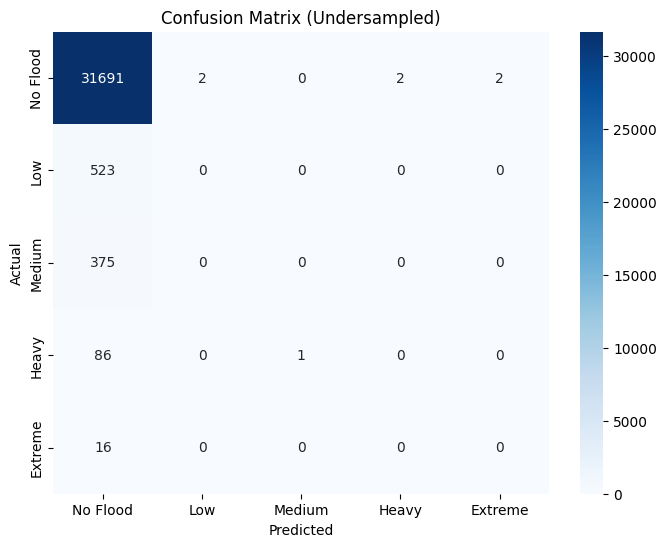


Generating Comparison Maps for ALL Scenarios...
   Mapping LIGHT...
   Mapping MEDIUM...
   Mapping HEAVY...
   Mapping EXTREME...


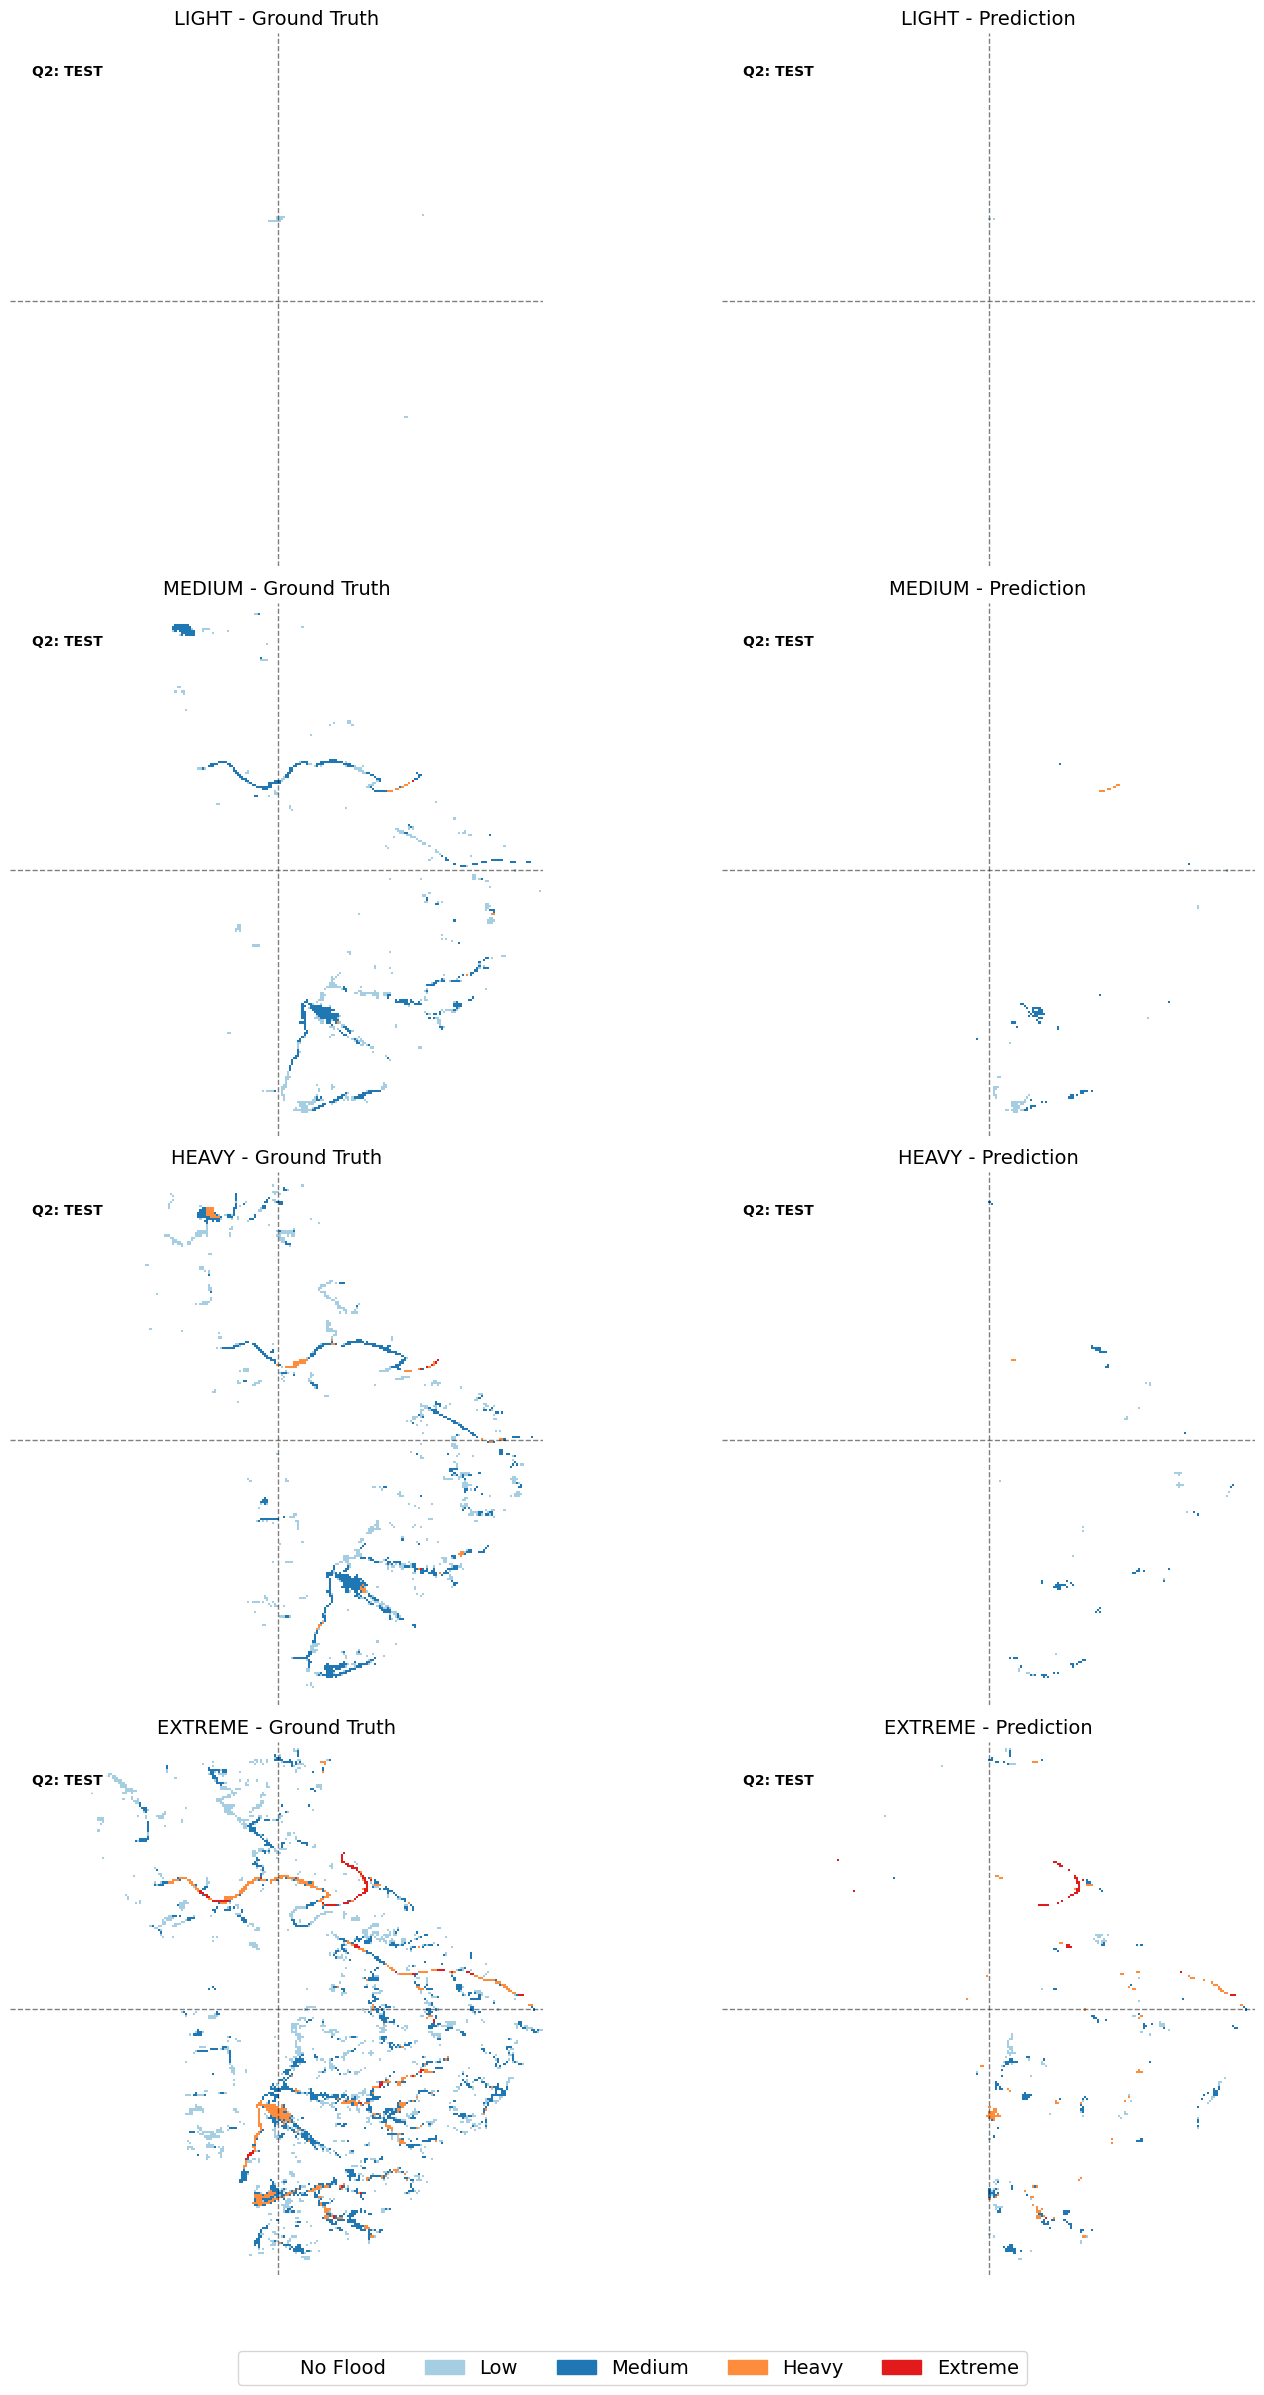

In [1]:
import numpy as np
import os
import rasterio
from rasterio.enums import Resampling
import gc
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
import seaborn as sns

# ================= CONFIGURATION =================
dem_npy_path     = "./processed_aux_map/processed_dem_numpy/dem_features.npy"
soil_npy_path    = "./processed_aux_map/processed_soil_numpy/soil_features.npy"
landuse_npy_path = "./processed_aux_map/processed_landuse_numpy/landuse_features.npy"
hyeto_dir        = "./processed_aux_map/hyetograph" 
flood_gt_dir     = "./processed_aux_map/ground_truth" 
manila_mask_path = "D:\\PC\\Documents\\SCHOOL\\GIT-THESIS\\XGBOOST-CONF\\manila_mask.tif"
scenario_map = {
    "LIGHT":   "L_Chicago_Water_Pixel.tif", 
    "MEDIUM":  "M_Chicago_Water_Pixel.tif", 
    "HEAVY":   "H_Chicago_Water_Pixel.tif",
    "EXTREME": "E_Chicago_Water_Pixel.tif"
}

H, W = 256, 256
num_pixels = H * W
# =================================================

print("STARTING SPATIAL PIPELINE (UNDERSAMPLING + LAND USE)...\n")

# load static features
print("Loading Static Features (DEM + Soil + LandUse)...")

if not os.path.exists(landuse_npy_path):
    raise FileNotFoundError("Land Use file missing! Run the Land Use processing script first.")

dem_data  = np.load(dem_npy_path)   # (3, H, W)
soil_data = np.load(soil_npy_path)  # (4, H, W)
lu_data   = np.load(landuse_npy_path) # (1, H, W) 

# Stack: 3 (DEM) + 4 (Soil) + 1 (LandUse) = 8 Channels
static_cube = np.concatenate([dem_data, soil_data, lu_data], axis=0)
static_cube = np.transpose(static_cube, (1, 2, 0)) 
X_static_flat = static_cube.reshape(-1, 8) 

print(f"   -> Static Features Shape: {X_static_flat.shape} (8 Features)")

del dem_data, soil_data, lu_data, static_cube
gc.collect()

#generate quadrants
print("Generating Spatial Quadrants...")
y_coords, x_coords = np.indices((H, W))
mid_y, mid_x = H // 2, W // 2

quadrant_map = np.zeros((H, W), dtype=int)
quadrant_map[(y_coords < mid_y) & (x_coords >= mid_x)] = 1 # Q1 (Train)
quadrant_map[(y_coords < mid_y) & (x_coords < mid_x)] = 2  # Q2 (Test)
quadrant_map[(y_coords >= mid_y) & (x_coords < mid_x)] = 3 # Q3 (Valid)
quadrant_map[(y_coords >= mid_y) & (x_coords >= mid_x)] = 4 # Q4 (Train)
quadrant_flat = quadrant_map.flatten()

#load manila mask
print(f"<mask> Loading Manila Mask from: {manila_mask_path}")
if not os.path.exists(manila_mask_path):
    raise FileNotFoundError("Mask file missing.")

with rasterio.open(manila_mask_path) as src:
    mask_arr = src.read(1, out_shape=(H, W), resampling=Resampling.nearest)
mask_flat = mask_arr.flatten()
is_in_manila = (mask_flat > 0)

#loop scenarios and split
X_train_list, y_train_list = [], []
X_val_list, y_val_list = [], []
X_test_list, y_test_list = [], []

print("\nProcessing Scenarios & Splitting spatially...")

for sc_name, gt_filename in scenario_map.items():
    
    # Paths Logic
    hyeto_filename = f"{sc_name}_chicago.npy" 
    hyeto_path = os.path.join(hyeto_dir, hyeto_filename)
    gt_path = os.path.join(flood_gt_dir, gt_filename)

    if not os.path.exists(hyeto_path):
        print(f"   Skipping {sc_name}: Rain file missing.")
        continue
    if not os.path.exists(gt_path):
         gt_path = os.path.join(flood_gt_dir, os.path.basename(gt_filename))
    if not os.path.exists(gt_path): 
        print(f"   Skipping {sc_name}: GT file missing.")
        continue

    # Load Rain
    rain_array = np.load(hyeto_path)
    if rain_array.ndim > 1: rain_array = rain_array.flatten()

    # Create Feature Table (8 Static + 5 Rain = 13 Features)
    rain_flat = np.tile(rain_array, (num_pixels, 1))
    X_scenario = np.hstack([X_static_flat, rain_flat])
    
    # Load Labels
    with rasterio.open(gt_path) as src:
        flood_arr = src.read(1, out_shape=(H, W), resampling=Resampling.nearest)
    y_scenario = flood_arr.flatten()
    
    # Apply Mask (Inside Manila + Valid Data)
    valid_pixels = is_in_manila & (y_scenario != -1) & (y_scenario != 255)
    
    # Split into Train/Test/Val based on Quadrants
    train_mask = valid_pixels & ((quadrant_flat == 1) | (quadrant_flat == 4))
    test_mask = valid_pixels & (quadrant_flat == 2)
    val_mask = valid_pixels & (quadrant_flat == 3)
    
    X_train_list.append(X_scenario[train_mask])
    y_train_list.append(y_scenario[train_mask])
    
    X_test_list.append(X_scenario[test_mask])
    y_test_list.append(y_scenario[test_mask])
    
    X_val_list.append(X_scenario[val_mask])
    y_val_list.append(y_scenario[val_mask])
    
    print(f"   -> {sc_name}: Train={np.sum(train_mask)} | Val={np.sum(val_mask)} | Test={np.sum(test_mask)}")

# merge splits
if len(X_train_list) == 0: raise ValueError("No data loaded!")

X_train = np.vstack(X_train_list)
y_train = np.concatenate(y_train_list)
X_val = np.vstack(X_val_list)
y_val = np.concatenate(y_val_list)
X_test = np.vstack(X_test_list)
y_test = np.concatenate(y_test_list)

print(f"Split Complete. Train Size: {len(y_train)}")


print("\nTraining XGBoost...")
model = XGBClassifier(
    n_estimators=1000,
    learning_rate=0.03,    
    max_depth=10,        
    min_child_weight=1,    
    gamma=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='multi:softmax',
    num_class=5,
    n_jobs=-1,
    random_state=42,
    early_stopping_rounds=20 
)

model.fit(
    X_train, 
    y_train, 
    eval_set=[(X_val, y_val)], 
    verbose=True
)

# evaluate on test set
print("\nEvaluating on TEST Quadrant (Q2)...")
if len(y_test) > 0:
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"Spatial Test Accuracy: {acc * 100:.2f}%")

    target_names = ["No Flood", "Low", "Medium", "Heavy", "Extreme"]
    unique_test = np.unique(y_test)
    names_present = [target_names[i] for i in unique_test if i < len(target_names)]

    print(classification_report(y_test, y_pred, target_names=names_present))

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=names_present, yticklabels=names_present)
    plt.title('Confusion Matrix (Undersampled)')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
else:
    print("Test set empty.")

# --- STEP 8: VISUALIZATION (ALL SCENARIOS) ---
print("\nGenerating Comparison Maps for ALL Scenarios...")

scenarios_to_plot = ["LIGHT", "MEDIUM", "HEAVY", "EXTREME"]
flood_cmap = ListedColormap(['white', '#a6cee3', '#1f78b4', '#fd8d3c', '#e31a1c'])
classes = ['No Flood', 'Low', 'Medium', 'Heavy', 'Extreme']

fig, axes = plt.subplots(4, 2, figsize=(16, 24))

def draw_quadrants(ax):
    mid_y, mid_x = H // 2, W // 2
    ax.axvline(x=mid_x, color='black', linestyle='--', linewidth=1, alpha=0.5)
    ax.axhline(y=mid_y, color='black', linestyle='--', linewidth=1, alpha=0.5)
    ax.text(10, 20, "Q2: TEST", fontsize=10, fontweight='bold', bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))

for idx, sc_name in enumerate(scenarios_to_plot):
    print(f"   Mapping {sc_name}...")
    
    # 1. Load Rain & GT
    hyeto_file = os.path.join(hyeto_dir, f"{sc_name}_chicago.npy")
    gt_file = scenario_map[sc_name]
    if not os.path.exists(gt_file): gt_file = os.path.join(flood_gt_dir, os.path.basename(gt_file))

    if not os.path.exists(hyeto_file) or not os.path.exists(gt_file):
        continue

    # Load Rain
    rain_vals = np.load(hyeto_file)
    if rain_vals.ndim > 1: rain_vals = rain_vals.flatten()
    rain_layer = np.tile(rain_vals, (num_pixels, 1))
    
    # Construct Features (Static[8] + Rain[5])
    X_full = np.hstack([X_static_flat, rain_layer])

    # Load Ground Truth
    with rasterio.open(gt_file) as src:
        y_gt_full = src.read(1, out_shape=(H, W), resampling=Resampling.nearest).flatten()

    # 2. Filter & Predict
    valid_indices = is_in_manila & (y_gt_full != -1) & (y_gt_full != 255)
    
    if np.sum(valid_indices) > 0:
        X_to_predict = X_full[valid_indices]
        y_pred_vis = model.predict(X_to_predict)

        # 3. Reconstruct Maps
        flat_gt = np.full(num_pixels, np.nan)
        flat_pred = np.full(num_pixels, np.nan)

        flat_gt[valid_indices] = y_gt_full[valid_indices]
        flat_pred[valid_indices] = y_pred_vis

        map_gt = flat_gt.reshape(H, W)
        map_pred = flat_pred.reshape(H, W)

        # 4. Plot
        ax_gt = axes[idx, 0]
        ax_gt.imshow(map_gt, cmap=flood_cmap, vmin=0, vmax=4, interpolation='nearest')
        ax_gt.set_title(f"{sc_name} - Ground Truth", fontsize=14)
        draw_quadrants(ax_gt)
        ax_gt.axis('off')

        ax_pred = axes[idx, 1]
        ax_pred.imshow(map_pred, cmap=flood_cmap, vmin=0, vmax=4, interpolation='nearest')
        ax_pred.set_title(f"{sc_name} - Prediction", fontsize=14)
        draw_quadrants(ax_pred)
        ax_pred.axis('off')

# Legend
patches = [mpatches.Patch(color=c, label=l) for c, l in zip(['white', '#a6cee3', '#1f78b4', '#fd8d3c', '#e31a1c'], classes)]
fig.legend(handles=patches, loc='lower center', ncol=5, fontsize=14, frameon=True)

plt.tight_layout()
plt.subplots_adjust(bottom=0.05)
plt.show()

The study estimates flood depth categories by applying a proportional scaling method defined as Depth Range (m) = L × f, where L represents the minimum ground clearance or height, and f is the fraction indicating the degree of submergence. This approach converts relative submergence ratios into measurable depth values by multiplying the fixed clearance height by predefined fractional ranges corresponding to flood severity levels. Using this method, the model systematically generates depth thresholds for categories such as no flood, low, medium, heavy, and extreme by adjusting only the fraction values while keeping the clearance height constant. This ensures consistency across scenarios and provides a mathematically grounded way to map fractional inundation to real-world depth measurements in meters.

# FINAL - with solution 

### SMOTE SOLUTION

🚀 STARTING SPATIAL PIPELINE (LAND USE + SMOTE + WEIGHTS)...

1️⃣ Loading Static Features (DEM + Soil + LandUse)...
   -> Static Features Shape: (65536, 8) (8 Features)
2️⃣ Generating Spatial Quadrants...
<mask> Loading Manila Mask from: D:\PC\Documents\SCHOOL\GIT-THESIS\XGBOOST-CONF\manila_mask.tif

3️⃣ Processing Scenarios & Splitting spatially...
   -> LIGHT: Train=18001 | Val=2397 | Test=7982
   -> MEDIUM: Train=18001 | Val=2677 | Test=8295
   -> HEAVY: Train=17979 | Val=1615 | Test=7283
   -> EXTREME: Train=18001 | Val=4174 | Test=9138

✅ SPLIT COMPLETE
TRAIN (Q1+Q4): 71982 samples
VALID (Q3):    10863 samples
TEST  (Q2):    32698 samples

⚖️ Calculating Sample Weights...
   -> Initial Weights Calcuated.
   -> Applying SMOTE to features...
   -> SMOTE Complete. New Train Size: 337260
   -> Recalculating weights for SMOTE dataset...

🚀 Training XGBoost with Weighted Loss...
[0]	validation_0-mlogloss:1.56474
[1]	validation_0-mlogloss:1.52605
[2]	validation_0-mlogloss:1.49049
[3]	vali

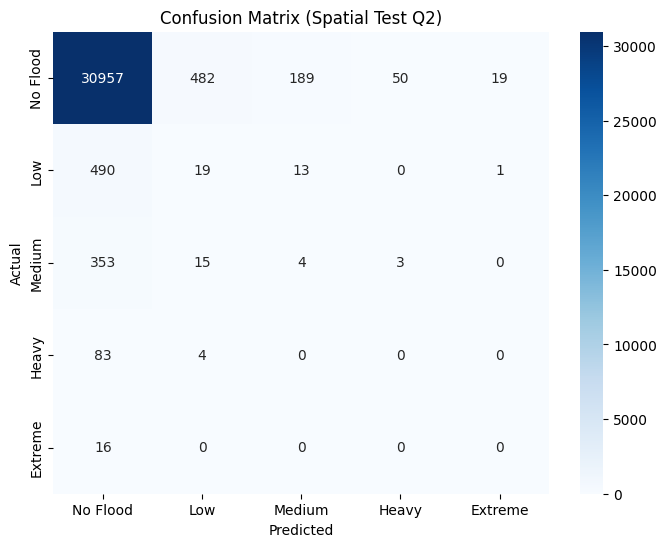


🗺️ Generating Comparison Maps for ALL Scenarios...
   Mapping LIGHT...
   Mapping MEDIUM...
   Mapping HEAVY...
   Mapping EXTREME...


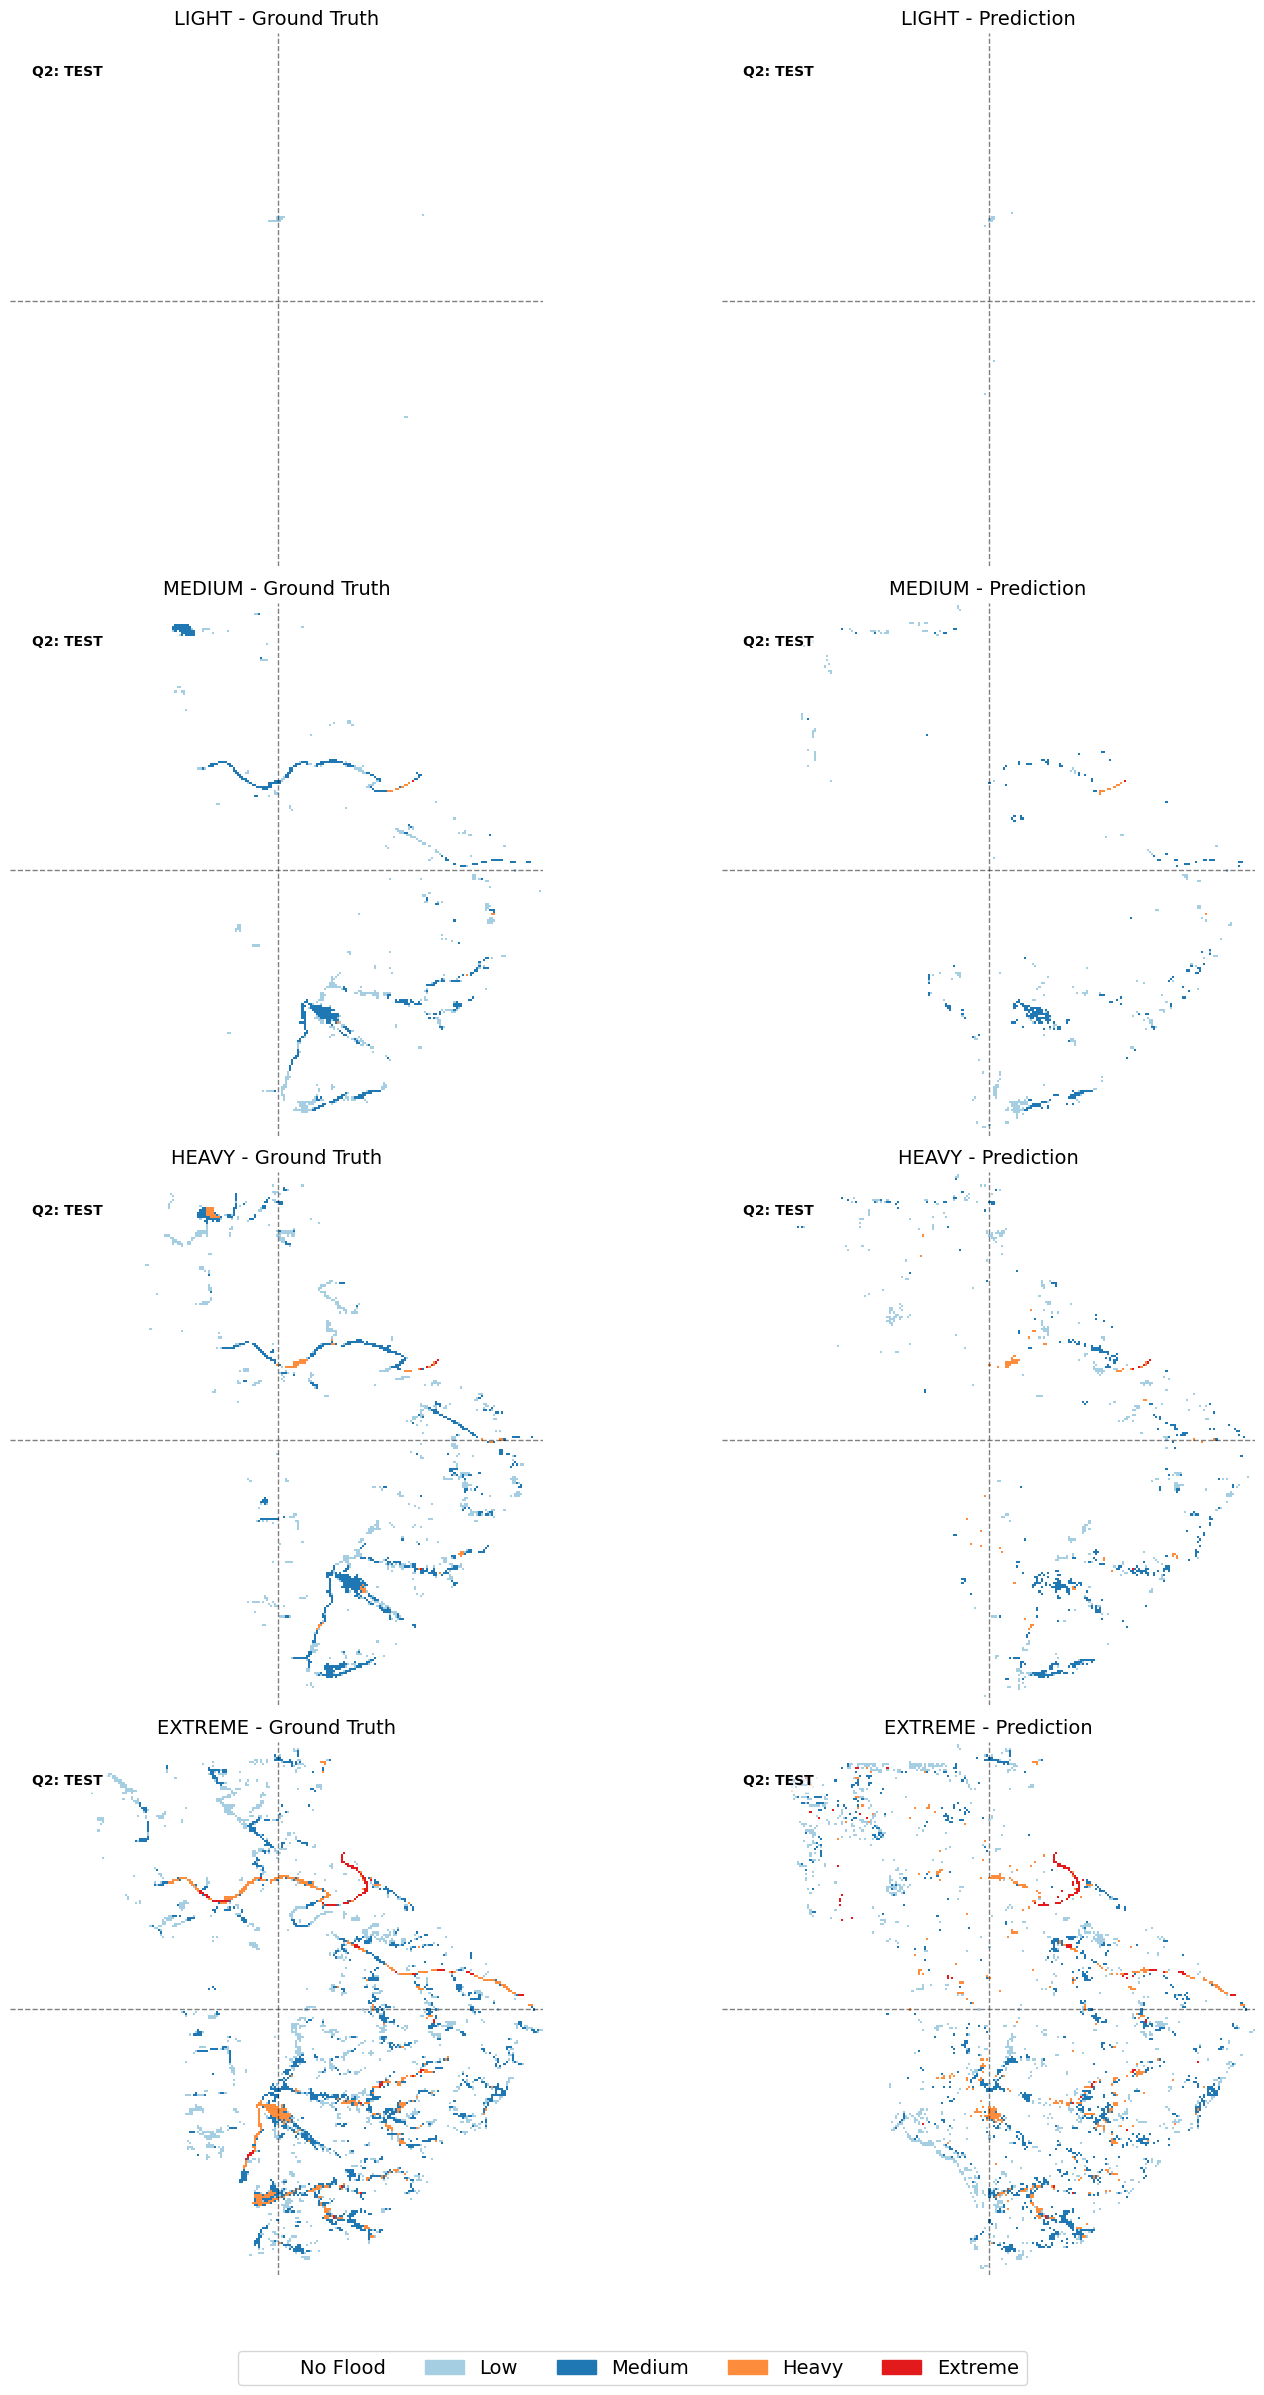


💾 Model Saved.


In [22]:
import numpy as np
import os
import rasterio
from rasterio.enums import Resampling
import gc
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE 
from sklearn.utils.class_weight import compute_sample_weight
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
import seaborn as sns

# ================= CONFIGURATION =================
# 1. PATHS
dem_npy_path     = "./processed_aux_map/processed_dem_numpy/dem_features.npy"
soil_npy_path    = "./processed_aux_map/processed_soil_numpy/soil_features.npy"
landuse_npy_path = "./processed_aux_map/processed_landuse_numpy/landuse_features.npy" # <--- ADDED

hyeto_dir        = "./processed_aux_map/hyetograph" 
flood_gt_dir     = "./processed_aux_map/ground_truth" 
manila_mask_path = "D:\\PC\\Documents\\SCHOOL\\GIT-THESIS\\XGBOOST-CONF\\manila_mask.tif"

# 2. SCENARIOS
scenario_map = {
    "LIGHT":   "L_Chicago_Water_Pixel.tif", 
    "MEDIUM":  "M_Chicago_Water_Pixel.tif", 
    "HEAVY":   "H_Chicago_Water_Pixel.tif",
    "EXTREME": "E_Chicago_Water_Pixel.tif"
}

H, W = 256, 256
num_pixels = H * W
# =================================================

print("🚀 STARTING SPATIAL PIPELINE (LAND USE + SMOTE + WEIGHTS)...\n")

# --- STEP 1: LOAD STATIC FEATURES ---
print("1️⃣ Loading Static Features (DEM + Soil + LandUse)...")

if not os.path.exists(landuse_npy_path):
    raise FileNotFoundError("❌ Land Use file missing! Run the Land Use processing script first.")

dem_data  = np.load(dem_npy_path)   # (3, H, W)
soil_data = np.load(soil_npy_path)  # (4, H, W)
lu_data   = np.load(landuse_npy_path) # (1, H, W) <--- NEW

# Stack: 3 (DEM) + 4 (Soil) + 1 (LandUse) = 8 Channels
static_cube = np.concatenate([dem_data, soil_data, lu_data], axis=0)
static_cube = np.transpose(static_cube, (1, 2, 0)) 
X_static_flat = static_cube.reshape(-1, 8)

print(f"   -> Static Features Shape: {X_static_flat.shape} (8 Features)")

del dem_data, soil_data, lu_data, static_cube
gc.collect()

# --- STEP 2: GENERATE QUADRANT MASK ---
print("2️⃣ Generating Spatial Quadrants...")
y_coords, x_coords = np.indices((H, W))
mid_y, mid_x = H // 2, W // 2

quadrant_map = np.zeros((H, W), dtype=int)
quadrant_map[(y_coords < mid_y) & (x_coords >= mid_x)] = 1 # Q1 (Train)
quadrant_map[(y_coords < mid_y) & (x_coords < mid_x)] = 2  # Q2 (Test)
quadrant_map[(y_coords >= mid_y) & (x_coords < mid_x)] = 3 # Q3 (Valid)
quadrant_map[(y_coords >= mid_y) & (x_coords >= mid_x)] = 4 # Q4 (Train)
quadrant_flat = quadrant_map.flatten()

# --- STEP 3: LOAD MANILA MASK ---
print(f"<mask> Loading Manila Mask from: {manila_mask_path}")
if not os.path.exists(manila_mask_path):
    raise FileNotFoundError("Mask file missing.")

with rasterio.open(manila_mask_path) as src:
    mask_arr = src.read(1, out_shape=(H, W), resampling=Resampling.nearest)
mask_flat = mask_arr.flatten()
is_in_manila = (mask_flat > 0)

# --- STEP 4: LOOP SCENARIOS AND SPLIT ---
X_train_list, y_train_list = [], []
X_val_list, y_val_list = [], []
X_test_list, y_test_list = [], []

print("\n3️⃣ Processing Scenarios & Splitting spatially...")

for sc_name, gt_filename in scenario_map.items():
    
    # Paths Logic
    hyeto_filename = f"{sc_name}_chicago.npy"
    hyeto_path = os.path.join(hyeto_dir, hyeto_filename)
    gt_path = os.path.join(flood_gt_dir, gt_filename)

    if not os.path.exists(hyeto_path):
        print(f"   ⚠️ Skipping {sc_name}: Rain file missing.")
        continue
    if not os.path.exists(gt_path):
         gt_path = os.path.join(flood_gt_dir, os.path.basename(gt_filename))
    if not os.path.exists(gt_path): 
        print(f"   ⚠️ Skipping {sc_name}: GT file missing.")
        continue

    # Load Rain
    rain_array = np.load(hyeto_path)
    if rain_array.ndim > 1: rain_array = rain_array.flatten()

    # Create Feature Table (8 Static + 5 Rain = 13 Features)
    rain_flat = np.tile(rain_array, (num_pixels, 1))
    X_scenario = np.hstack([X_static_flat, rain_flat])
    
    # Load Labels
    with rasterio.open(gt_path) as src:
        flood_arr = src.read(1, out_shape=(H, W), resampling=Resampling.nearest)
    y_scenario = flood_arr.flatten()
    
    # Apply Mask (Inside Manila + Valid Data)
    valid_pixels = is_in_manila & (y_scenario != -1) & (y_scenario != 255)
    
    # Split into Train/Test/Val based on Quadrants
    train_mask = valid_pixels & ((quadrant_flat == 1) | (quadrant_flat == 4))
    test_mask = valid_pixels & (quadrant_flat == 2)
    val_mask = valid_pixels & (quadrant_flat == 3)
    
    X_train_list.append(X_scenario[train_mask])
    y_train_list.append(y_scenario[train_mask])
    
    X_test_list.append(X_scenario[test_mask])
    y_test_list.append(y_scenario[test_mask])
    
    X_val_list.append(X_scenario[val_mask])
    y_val_list.append(y_scenario[val_mask])
    
    print(f"   -> {sc_name}: Train={np.sum(train_mask)} | Val={np.sum(val_mask)} | Test={np.sum(test_mask)}")

# --- STEP 5: MERGE & CHECK ---
if len(X_train_list) == 0: raise ValueError("❌ No data loaded!")

X_train = np.vstack(X_train_list)
y_train = np.concatenate(y_train_list)
X_val = np.vstack(X_val_list)
y_val = np.concatenate(y_val_list)
X_test = np.vstack(X_test_list)
y_test = np.concatenate(y_test_list)

print("\n✅ SPLIT COMPLETE")
print(f"TRAIN (Q1+Q4): {X_train.shape[0]} samples")
print(f"VALID (Q3):    {X_val.shape[0]} samples")
print(f"TEST  (Q2):    {X_test.shape[0]} samples")

# --- STEP 6: HANDLING IMBALANCE (WEIGHTS + SMOTE) ---
print("\n⚖️ Calculating Sample Weights...")

# 1. Weights based on raw data
weights = compute_sample_weight(class_weight='balanced', y=y_train)
print(f"   -> Initial Weights Calcuated.")

# 2. Apply SMOTE
print("   -> Applying SMOTE to features...")
# k_neighbors=1 is safer for extremely rare classes
smote = SMOTE(random_state=42, k_neighbors=1) 
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print(f"   -> SMOTE Complete. New Train Size: {X_train_smote.shape[0]}")

# 3. Recalculate weights for the NEW SMOTE-d dataset
# (SMOTE creates new rows, so old weights array is now too short)
print("   -> Recalculating weights for SMOTE dataset...")
weights_smote = compute_sample_weight(class_weight='balanced', y=y_train_smote)

print("\n🚀 Training XGBoost with Weighted Loss...")
model = XGBClassifier(
    n_estimators=1500,
    learning_rate=0.05,
    max_depth=8,
    gamma=0.2,
    reg_lambda=1.0,
    objective='multi:softmax',
    num_class=5,
    n_jobs=-1,
    random_state=42,
    early_stopping_rounds=30 
)

# PASS THE WEIGHTS HERE 👇
model.fit(
    X_train_smote, 
    y_train_smote, 
    sample_weight=weights_smote, 
    eval_set=[(X_val, y_val)], 
    verbose=True
)

# --- STEP 7: EVALUATION ---
print("\n📊 Evaluating on TEST Quadrant (Q2)...")
if X_test.shape[0] > 0:
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"✅ Spatial Test Accuracy: {acc * 100:.2f}%")

    target_names = ["No Flood", "Low", "Medium", "Heavy", "Extreme"]
    unique_test = np.unique(y_test)
    names_present = [target_names[i] for i in unique_test if i < len(target_names)]

    print(classification_report(y_test, y_pred, target_names=names_present))

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=names_present, yticklabels=names_present)
    plt.title('Confusion Matrix (Spatial Test Q2)')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
else:
    print("⚠️ Skipping Evaluation (Test set empty)")

# --- STEP 8: VISUALIZATION (ALL SCENARIOS) ---
print("\n🗺️ Generating Comparison Maps for ALL Scenarios...")

scenarios_to_plot = ["LIGHT", "MEDIUM", "HEAVY", "EXTREME"]
flood_cmap = ListedColormap(['white', '#a6cee3', '#1f78b4', '#fd8d3c', '#e31a1c'])
classes = ['No Flood', 'Low', 'Medium', 'Heavy', 'Extreme']

fig, axes = plt.subplots(4, 2, figsize=(16, 24))

def draw_quadrants(ax):
    # Crosshair
    ax.axvline(x=mid_x, color='black', linestyle='--', linewidth=1, alpha=0.5)
    ax.axhline(y=mid_y, color='black', linestyle='--', linewidth=1, alpha=0.5)
    # Labels
    ax.text(10, 20, "Q2: TEST", fontsize=10, fontweight='bold', bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))

for idx, sc_name in enumerate(scenarios_to_plot):
    print(f"   Mapping {sc_name}...")
    
    # 1. Load Rain & GT
    hyeto_file = os.path.join(hyeto_dir, f"{sc_name}_chicago.npy")
    gt_file = scenario_map[sc_name]
    if not os.path.exists(gt_file): gt_file = os.path.join(flood_gt_dir, os.path.basename(gt_file))

    if not os.path.exists(hyeto_file) or not os.path.exists(gt_file):
        continue

    # Load Rain
    rain_vals = np.load(hyeto_file)
    if rain_vals.ndim > 1: rain_vals = rain_vals.flatten()
    rain_layer = np.tile(rain_vals, (num_pixels, 1))
    
    # Construct Features (Static[8] + Rain[5])
    X_full = np.hstack([X_static_flat, rain_layer])

    # Load Ground Truth
    with rasterio.open(gt_file) as src:
        y_gt_full = src.read(1, out_shape=(H, W), resampling=Resampling.nearest).flatten()

    # 2. Filter & Predict
    valid_indices = is_in_manila & (y_gt_full != -1) & (y_gt_full != 255)
    
    if np.sum(valid_indices) > 0:
        X_to_predict = X_full[valid_indices]
        y_pred_vis = model.predict(X_to_predict)

        # 3. Reconstruct Maps
        flat_gt = np.full(num_pixels, np.nan)
        flat_pred = np.full(num_pixels, np.nan)

        flat_gt[valid_indices] = y_gt_full[valid_indices]
        flat_pred[valid_indices] = y_pred_vis

        map_gt = flat_gt.reshape(H, W)
        map_pred = flat_pred.reshape(H, W)

        # 4. Plot
        ax_gt = axes[idx, 0]
        ax_gt.imshow(map_gt, cmap=flood_cmap, vmin=0, vmax=4, interpolation='nearest')
        ax_gt.set_title(f"{sc_name} - Ground Truth", fontsize=14)
        draw_quadrants(ax_gt)
        ax_gt.axis('off')

        ax_pred = axes[idx, 1]
        ax_pred.imshow(map_pred, cmap=flood_cmap, vmin=0, vmax=4, interpolation='nearest')
        ax_pred.set_title(f"{sc_name} - Prediction", fontsize=14)
        draw_quadrants(ax_pred)
        ax_pred.axis('off')

# Legend
patches = [mpatches.Patch(color=c, label=l) for c, l in zip(['white', '#a6cee3', '#1f78b4', '#fd8d3c', '#e31a1c'], classes)]
fig.legend(handles=patches, loc='lower center', ncol=5, fontsize=14, frameon=True)

plt.tight_layout()
plt.subplots_adjust(bottom=0.05)
plt.show()

model.save_model("xgboost_smote_landuse.json")
print("\n💾 Model Saved.")

### UNDERSAMPLING 1

🚀 STARTING SPATIAL PIPELINE (UNDERSAMPLING + LAND USE)...

1️⃣ Loading Static Features (DEM + Soil + LandUse)...
   -> Static Features Shape: (65536, 8) (8 Features)
2️⃣ Generating Spatial Quadrants...
<mask> Loading Manila Mask from: D:\PC\Documents\SCHOOL\GIT-THESIS\XGBOOST-CONF\manila_mask.tif

3️⃣ Processing Scenarios & Splitting spatially...
   -> LIGHT: Train=18001 | Val=2397 | Test=7982
   -> MEDIUM: Train=18001 | Val=2677 | Test=8295
   -> HEAVY: Train=17979 | Val=1615 | Test=7283
   -> EXTREME: Train=18001 | Val=4174 | Test=9138
✅ Split Complete. Train Size: 71982

⚖️ Applying Aggressive Undersampling...
   Original -> No Flood: 67452 | Flood: 4530
   Balanced -> Total: 13590 (Floods: 4530)

🚀 Training XGBoost...
[0]	validation_0-mlogloss:1.18013
[1]	validation_0-mlogloss:1.15936
[2]	validation_0-mlogloss:1.13900
[3]	validation_0-mlogloss:1.12009
[4]	validation_0-mlogloss:1.10154
[5]	validation_0-mlogloss:1.08490
[6]	validation_0-mlogloss:1.06897
[7]	validation_0-mlogloss:1.05

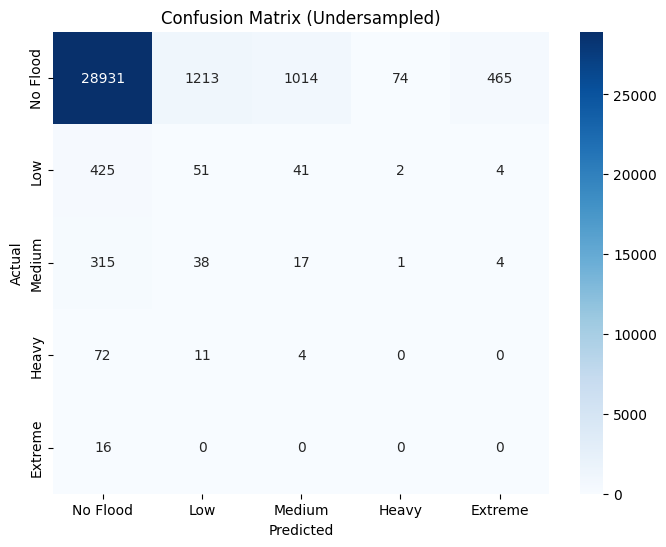


🗺️ Generating Comparison Maps for ALL Scenarios...
   Mapping LIGHT...
   Mapping MEDIUM...
   Mapping HEAVY...
   Mapping EXTREME...


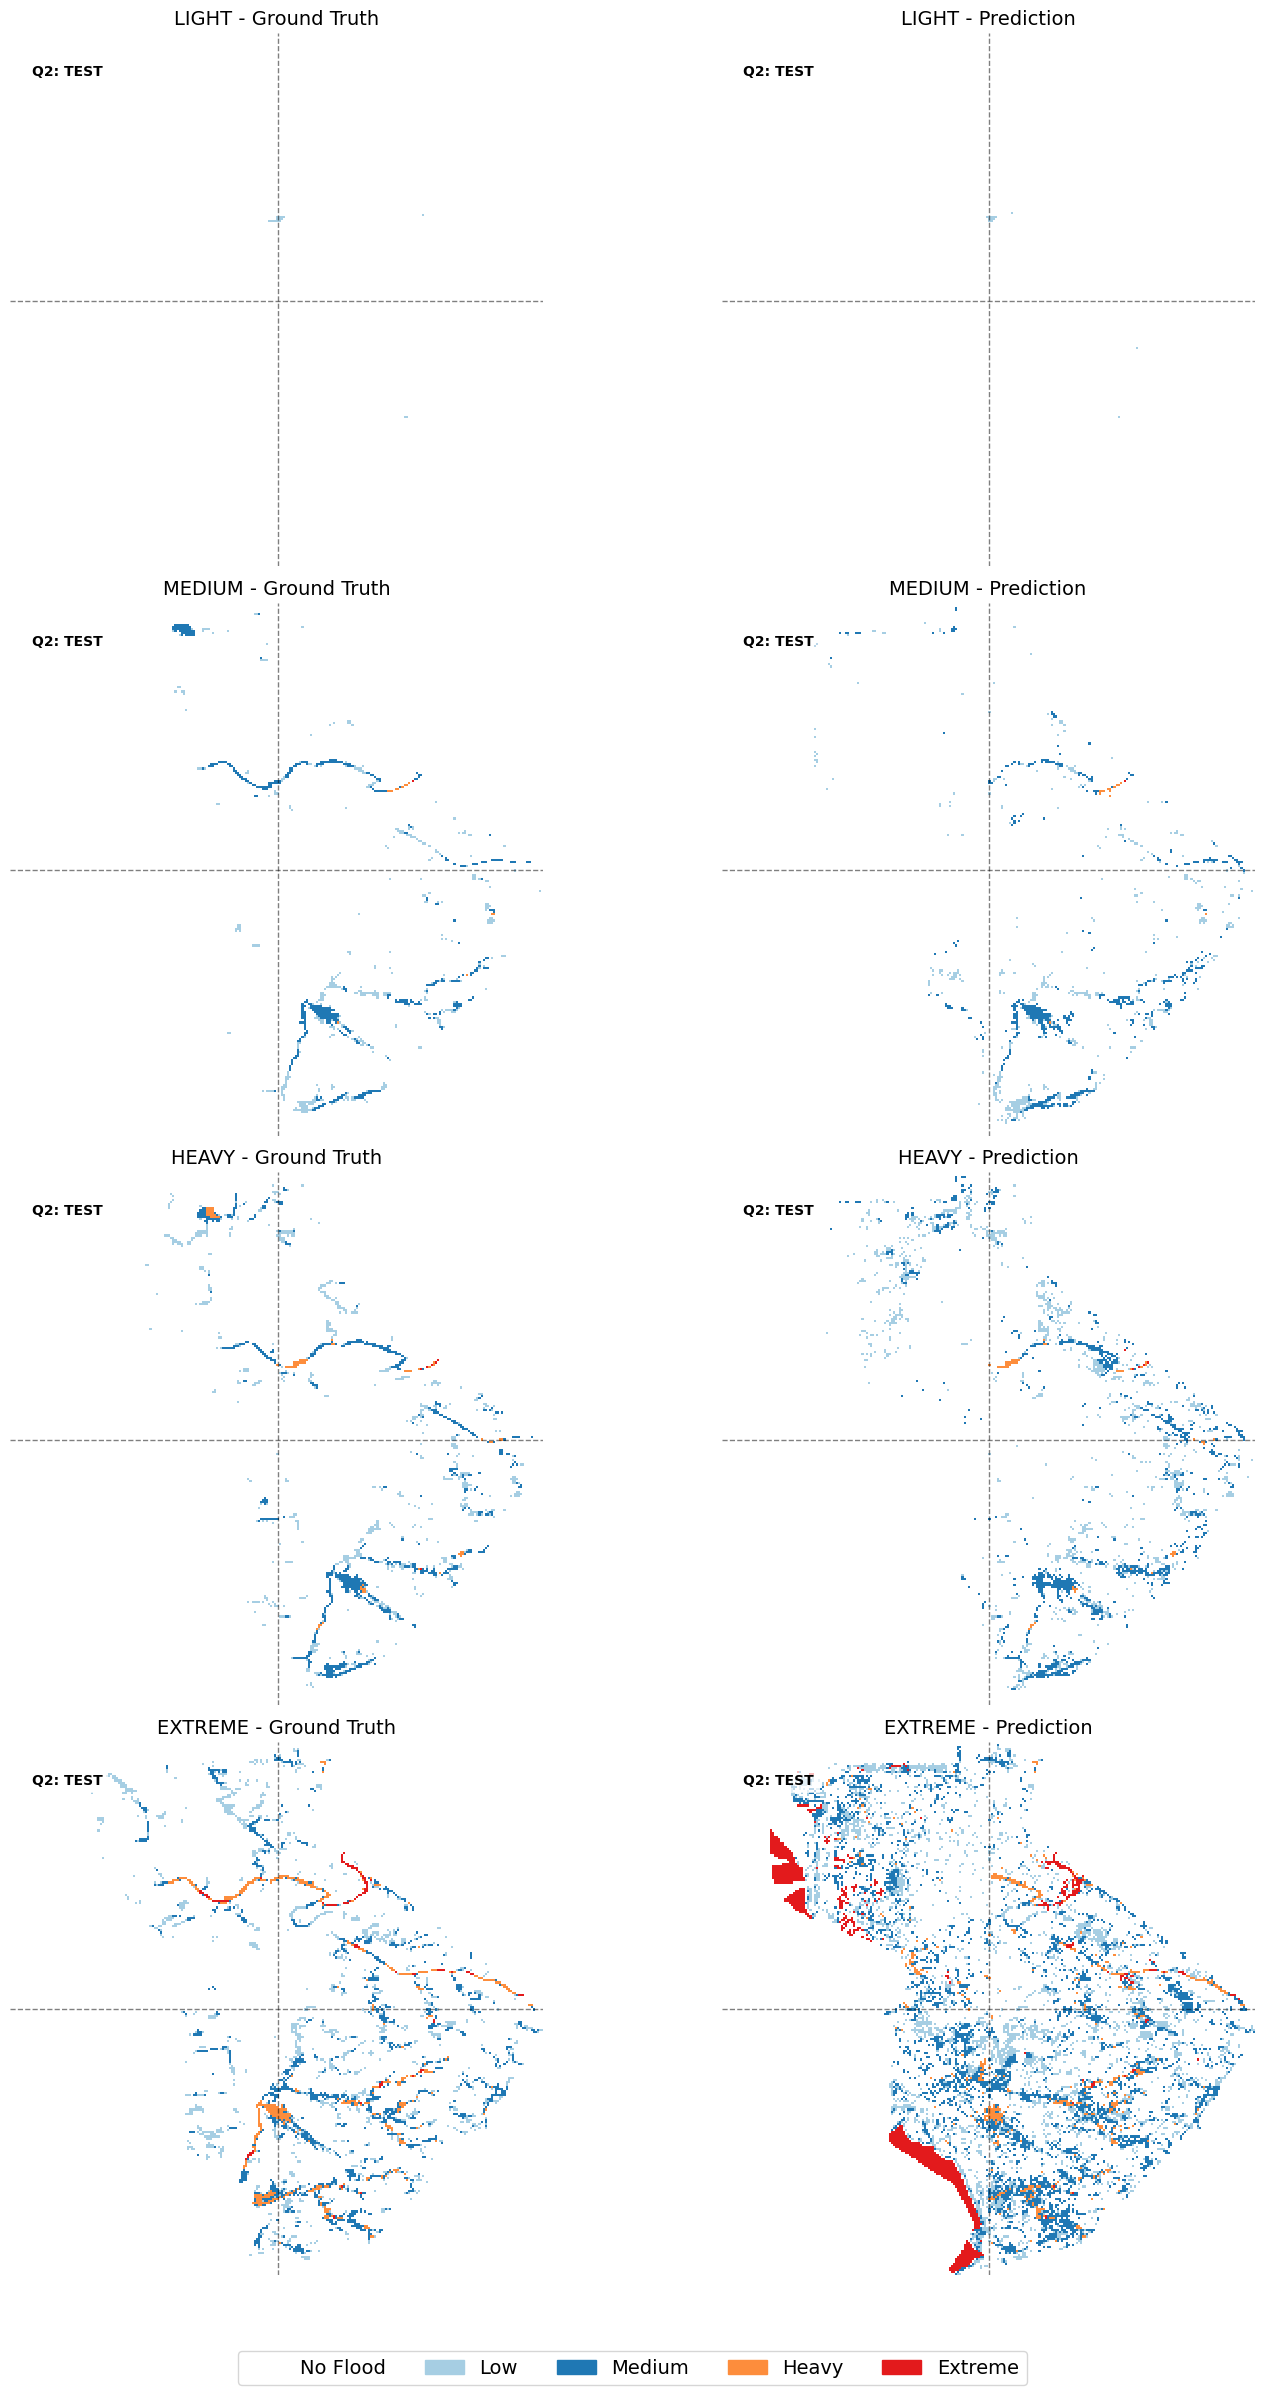


💾 Model Saved.


In [25]:
import numpy as np
import os
import rasterio
from rasterio.enums import Resampling
import gc
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
import seaborn as sns

# ================= CONFIGURATION =================
# 1. PATHS
dem_npy_path     = "./processed_aux_map/processed_dem_numpy/dem_features.npy"
soil_npy_path    = "./processed_aux_map/processed_soil_numpy/soil_features.npy"
landuse_npy_path = "./processed_aux_map/processed_landuse_numpy/landuse_features.npy" # <--- ADDED

hyeto_dir        = "./processed_aux_map/hyetograph" 
flood_gt_dir     = "./processed_aux_map/ground_truth" 
manila_mask_path = "D:\\PC\\Documents\\SCHOOL\\GIT-THESIS\\XGBOOST-CONF\\manila_mask.tif"

# 2. SCENARIOS
scenario_map = {
    "LIGHT":   "L_Chicago_Water_Pixel.tif", 
    "MEDIUM":  "M_Chicago_Water_Pixel.tif", 
    "HEAVY":   "H_Chicago_Water_Pixel.tif",
    "EXTREME": "E_Chicago_Water_Pixel.tif"
}

H, W = 256, 256
num_pixels = H * W
# =================================================

print("🚀 STARTING SPATIAL PIPELINE (UNDERSAMPLING + LAND USE)...\n")

# --- STEP 1: LOAD STATIC FEATURES ---
print("1️⃣ Loading Static Features (DEM + Soil + LandUse)...")

if not os.path.exists(landuse_npy_path):
    raise FileNotFoundError("❌ Land Use file missing! Run the Land Use processing script first.")

dem_data  = np.load(dem_npy_path)   # (3, H, W)
soil_data = np.load(soil_npy_path)  # (4, H, W)
lu_data   = np.load(landuse_npy_path) # (1, H, W) <--- NEW

# Stack: 3 (DEM) + 4 (Soil) + 1 (LandUse) = 8 Channels
static_cube = np.concatenate([dem_data, soil_data, lu_data], axis=0)
static_cube = np.transpose(static_cube, (1, 2, 0)) 
X_static_flat = static_cube.reshape(-1, 8)

print(f"   -> Static Features Shape: {X_static_flat.shape} (8 Features)")

del dem_data, soil_data, lu_data, static_cube
gc.collect()

# --- STEP 2: GENERATE QUADRANT MASK ---
print("2️⃣ Generating Spatial Quadrants...")
y_coords, x_coords = np.indices((H, W))
mid_y, mid_x = H // 2, W // 2

quadrant_map = np.zeros((H, W), dtype=int)
quadrant_map[(y_coords < mid_y) & (x_coords >= mid_x)] = 1 # Q1 (Train)
quadrant_map[(y_coords < mid_y) & (x_coords < mid_x)] = 2  # Q2 (Test)
quadrant_map[(y_coords >= mid_y) & (x_coords < mid_x)] = 3 # Q3 (Valid)
quadrant_map[(y_coords >= mid_y) & (x_coords >= mid_x)] = 4 # Q4 (Train)
quadrant_flat = quadrant_map.flatten()

# --- STEP 3: LOAD MANILA MASK ---
print(f"<mask> Loading Manila Mask from: {manila_mask_path}")
if not os.path.exists(manila_mask_path):
    raise FileNotFoundError("Mask file missing.")

with rasterio.open(manila_mask_path) as src:
    mask_arr = src.read(1, out_shape=(H, W), resampling=Resampling.nearest)
mask_flat = mask_arr.flatten()
is_in_manila = (mask_flat > 0)

# --- STEP 4: LOOP SCENARIOS AND SPLIT ---
X_train_list, y_train_list = [], []
X_val_list, y_val_list = [], []
X_test_list, y_test_list = [], []

print("\n3️⃣ Processing Scenarios & Splitting spatially...")

for sc_name, gt_filename in scenario_map.items():
    
    # Paths Logic
    hyeto_filename = f"{sc_name}_chicago.npy" 
    hyeto_path = os.path.join(hyeto_dir, hyeto_filename)
    gt_path = os.path.join(flood_gt_dir, gt_filename)

    if not os.path.exists(hyeto_path):
        print(f"   ⚠️ Skipping {sc_name}: Rain file missing.")
        continue
    if not os.path.exists(gt_path):
         gt_path = os.path.join(flood_gt_dir, os.path.basename(gt_filename))
    if not os.path.exists(gt_path): 
        print(f"   ⚠️ Skipping {sc_name}: GT file missing.")
        continue

    # Load Rain
    rain_array = np.load(hyeto_path)
    if rain_array.ndim > 1: rain_array = rain_array.flatten()

    # Create Feature Table (8 Static + 5 Rain = 13 Features)
    rain_flat = np.tile(rain_array, (num_pixels, 1))
    X_scenario = np.hstack([X_static_flat, rain_flat])
    
    # Load Labels
    with rasterio.open(gt_path) as src:
        flood_arr = src.read(1, out_shape=(H, W), resampling=Resampling.nearest)
    y_scenario = flood_arr.flatten()
    
    # Apply Mask (Inside Manila + Valid Data)
    valid_pixels = is_in_manila & (y_scenario != -1) & (y_scenario != 255)
    
    # Split into Train/Test/Val based on Quadrants
    train_mask = valid_pixels & ((quadrant_flat == 1) | (quadrant_flat == 4))
    test_mask = valid_pixels & (quadrant_flat == 2)
    val_mask = valid_pixels & (quadrant_flat == 3)
    
    X_train_list.append(X_scenario[train_mask])
    y_train_list.append(y_scenario[train_mask])
    
    X_test_list.append(X_scenario[test_mask])
    y_test_list.append(y_scenario[test_mask])
    
    X_val_list.append(X_scenario[val_mask])
    y_val_list.append(y_scenario[val_mask])
    
    print(f"   -> {sc_name}: Train={np.sum(train_mask)} | Val={np.sum(val_mask)} | Test={np.sum(test_mask)}")

# --- STEP 5: MERGE & CHECK ---
if len(X_train_list) == 0: raise ValueError("❌ No data loaded!")

X_train = np.vstack(X_train_list)
y_train = np.concatenate(y_train_list)
X_val = np.vstack(X_val_list)
y_val = np.concatenate(y_val_list)
X_test = np.vstack(X_test_list)
y_test = np.concatenate(y_test_list)

print(f"✅ Split Complete. Train Size: {len(y_train)}")

# --- STEP 6: AGGRESSIVE UNDERSAMPLING ---
print("\n⚖️ Applying Aggressive Undersampling...")

mask_no_flood = (y_train == 0)
mask_flood = (y_train > 0) # Classes 1, 2, 3, 4

X_flood = X_train[mask_flood]
y_flood = y_train[mask_flood]
X_no_flood = X_train[mask_no_flood]
y_no_flood = y_train[mask_no_flood]

print(f"   Original -> No Flood: {len(y_no_flood)} | Flood: {len(y_flood)}")

# Keep 2:1 ratio (2 Safe pixels for every 1 Flood pixel)
target_safe_count = len(y_flood) * 2
if target_safe_count > len(y_no_flood): target_safe_count = len(y_no_flood)

# Randomly select subset of safe pixels
indices = np.random.choice(len(y_no_flood), size=target_safe_count, replace=False)
X_no_flood_ds = X_no_flood[indices]
y_no_flood_ds = y_no_flood[indices]

# Combine & Shuffle
X_train_bal = np.vstack([X_flood, X_no_flood_ds])
y_train_bal = np.concatenate([y_flood, y_no_flood_ds])
X_train_bal, y_train_bal = shuffle(X_train_bal, y_train_bal, random_state=42)

print(f"   Balanced -> Total: {len(y_train_bal)} (Floods: {len(y_flood)})")

print("\n🚀 Training XGBoost...")
model = XGBClassifier(
    n_estimators=1000,
    learning_rate=0.03,    
    max_depth=10,          # Deeper trees
    min_child_weight=1,    # Allow small leaf nodes (crucial for rare classes)
    gamma=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='multi:softmax',
    num_class=5,
    n_jobs=-1,
    random_state=42,
    early_stopping_rounds=20 
)

model.fit(
    X_train_bal, 
    y_train_bal, 
    eval_set=[(X_val, y_val)], 
    verbose=True
)

# --- STEP 7: EVALUATION ---
print("\n📊 Evaluating on TEST Quadrant (Q2)...")
if len(y_test) > 0:
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"✅ Spatial Test Accuracy: {acc * 100:.2f}%")

    target_names = ["No Flood", "Low", "Medium", "Heavy", "Extreme"]
    unique_test = np.unique(y_test)
    names_present = [target_names[i] for i in unique_test if i < len(target_names)]

    print(classification_report(y_test, y_pred, target_names=names_present))

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=names_present, yticklabels=names_present)
    plt.title('Confusion Matrix (Undersampled)')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
else:
    print("⚠️ Test set empty.")

# --- STEP 8: VISUALIZATION (ALL SCENARIOS) ---
print("\n🗺️ Generating Comparison Maps for ALL Scenarios...")

scenarios_to_plot = ["LIGHT", "MEDIUM", "HEAVY", "EXTREME"]
flood_cmap = ListedColormap(['white', '#a6cee3', '#1f78b4', '#fd8d3c', '#e31a1c'])
classes = ['No Flood', 'Low', 'Medium', 'Heavy', 'Extreme']

fig, axes = plt.subplots(4, 2, figsize=(16, 24))

def draw_quadrants(ax):
    mid_y, mid_x = H // 2, W // 2
    ax.axvline(x=mid_x, color='black', linestyle='--', linewidth=1, alpha=0.5)
    ax.axhline(y=mid_y, color='black', linestyle='--', linewidth=1, alpha=0.5)
    ax.text(10, 20, "Q2: TEST", fontsize=10, fontweight='bold', bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))

for idx, sc_name in enumerate(scenarios_to_plot):
    print(f"   Mapping {sc_name}...")
    
    # 1. Load Rain & GT
    hyeto_file = os.path.join(hyeto_dir, f"{sc_name}_chicago.npy")
    gt_file = scenario_map[sc_name]
    if not os.path.exists(gt_file): gt_file = os.path.join(flood_gt_dir, os.path.basename(gt_file))

    if not os.path.exists(hyeto_file) or not os.path.exists(gt_file):
        continue

    # Load Rain
    rain_vals = np.load(hyeto_file)
    if rain_vals.ndim > 1: rain_vals = rain_vals.flatten()
    rain_layer = np.tile(rain_vals, (num_pixels, 1))
    
    # Construct Features (Static[8] + Rain[5])
    X_full = np.hstack([X_static_flat, rain_layer])

    # Load Ground Truth
    with rasterio.open(gt_file) as src:
        y_gt_full = src.read(1, out_shape=(H, W), resampling=Resampling.nearest).flatten()

    # 2. Filter & Predict
    valid_indices = is_in_manila & (y_gt_full != -1) & (y_gt_full != 255)
    
    if np.sum(valid_indices) > 0:
        X_to_predict = X_full[valid_indices]
        y_pred_vis = model.predict(X_to_predict)

        # 3. Reconstruct Maps
        flat_gt = np.full(num_pixels, np.nan)
        flat_pred = np.full(num_pixels, np.nan)

        flat_gt[valid_indices] = y_gt_full[valid_indices]
        flat_pred[valid_indices] = y_pred_vis

        map_gt = flat_gt.reshape(H, W)
        map_pred = flat_pred.reshape(H, W)

        # 4. Plot
        ax_gt = axes[idx, 0]
        ax_gt.imshow(map_gt, cmap=flood_cmap, vmin=0, vmax=4, interpolation='nearest')
        ax_gt.set_title(f"{sc_name} - Ground Truth", fontsize=14)
        draw_quadrants(ax_gt)
        ax_gt.axis('off')

        ax_pred = axes[idx, 1]
        ax_pred.imshow(map_pred, cmap=flood_cmap, vmin=0, vmax=4, interpolation='nearest')
        ax_pred.set_title(f"{sc_name} - Prediction", fontsize=14)
        draw_quadrants(ax_pred)
        ax_pred.axis('off')

# Legend
patches = [mpatches.Patch(color=c, label=l) for c, l in zip(['white', '#a6cee3', '#1f78b4', '#fd8d3c', '#e31a1c'], classes)]
fig.legend(handles=patches, loc='lower center', ncol=5, fontsize=14, frameon=True)

plt.tight_layout()
plt.subplots_adjust(bottom=0.05)
plt.show()

model.save_model("xgboost_undersampled_landuse.json")
print("\n💾 Model Saved.")

### UNDERSAMPLING 2 

🚀 STARTING SPATIAL PIPELINE (HYBRID SAMPLING + LAND USE)...

1️⃣ Loading Static Features (DEM + Soil + LandUse)...
   -> Static Features Shape: (65536, 8) (8 Features)
2️⃣ Generating Spatial Quadrants...
<mask> Loading Manila Mask from: D:\PC\Documents\SCHOOL\GIT-THESIS\XGBOOST-CONF\manila_mask.tif

3️⃣ Processing Scenarios & Splitting spatially...
   -> LIGHT: Train=18001 | Val=2397 | Test=7982
   -> MEDIUM: Train=18001 | Val=2677 | Test=8295
   -> HEAVY: Train=17979 | Val=1615 | Test=7283
   -> EXTREME: Train=18001 | Val=4174 | Test=9138
✅ Split Complete. Raw Train Size: 71982

⚖️ Applying Hybrid Sampling (Undersample Safe, Oversample Extreme)...
   Original Counts: 0:67452 | 1:1998 | 2:2048 | 3:396 | 4:88
   -> Target per class: ~1998
   -> Final Training Size: 11988

🚀 Training XGBoost...
[0]	validation_0-mlogloss:1.46097
[1]	validation_0-mlogloss:1.43924
[2]	validation_0-mlogloss:1.41939
[3]	validation_0-mlogloss:1.39686
[4]	validation_0-mlogloss:1.37728
[5]	validation_0-mlogloss:

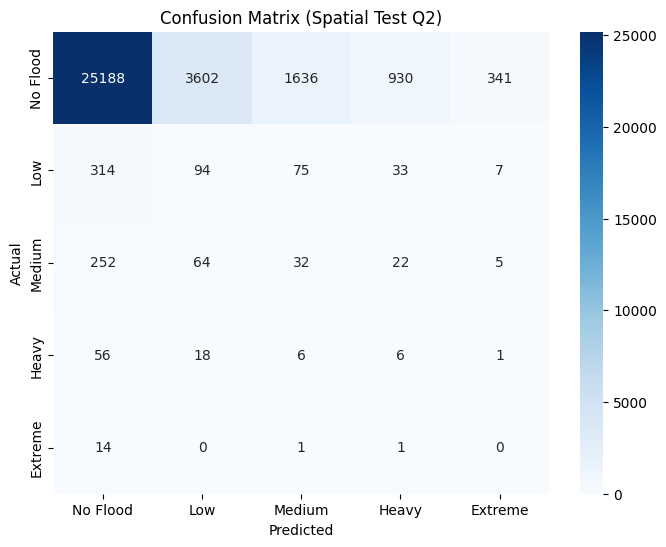


🗺️ Generating Comparison Maps for ALL Scenarios...
   Processing LIGHT...
   Processing MEDIUM...
   Processing HEAVY...
   Processing EXTREME...


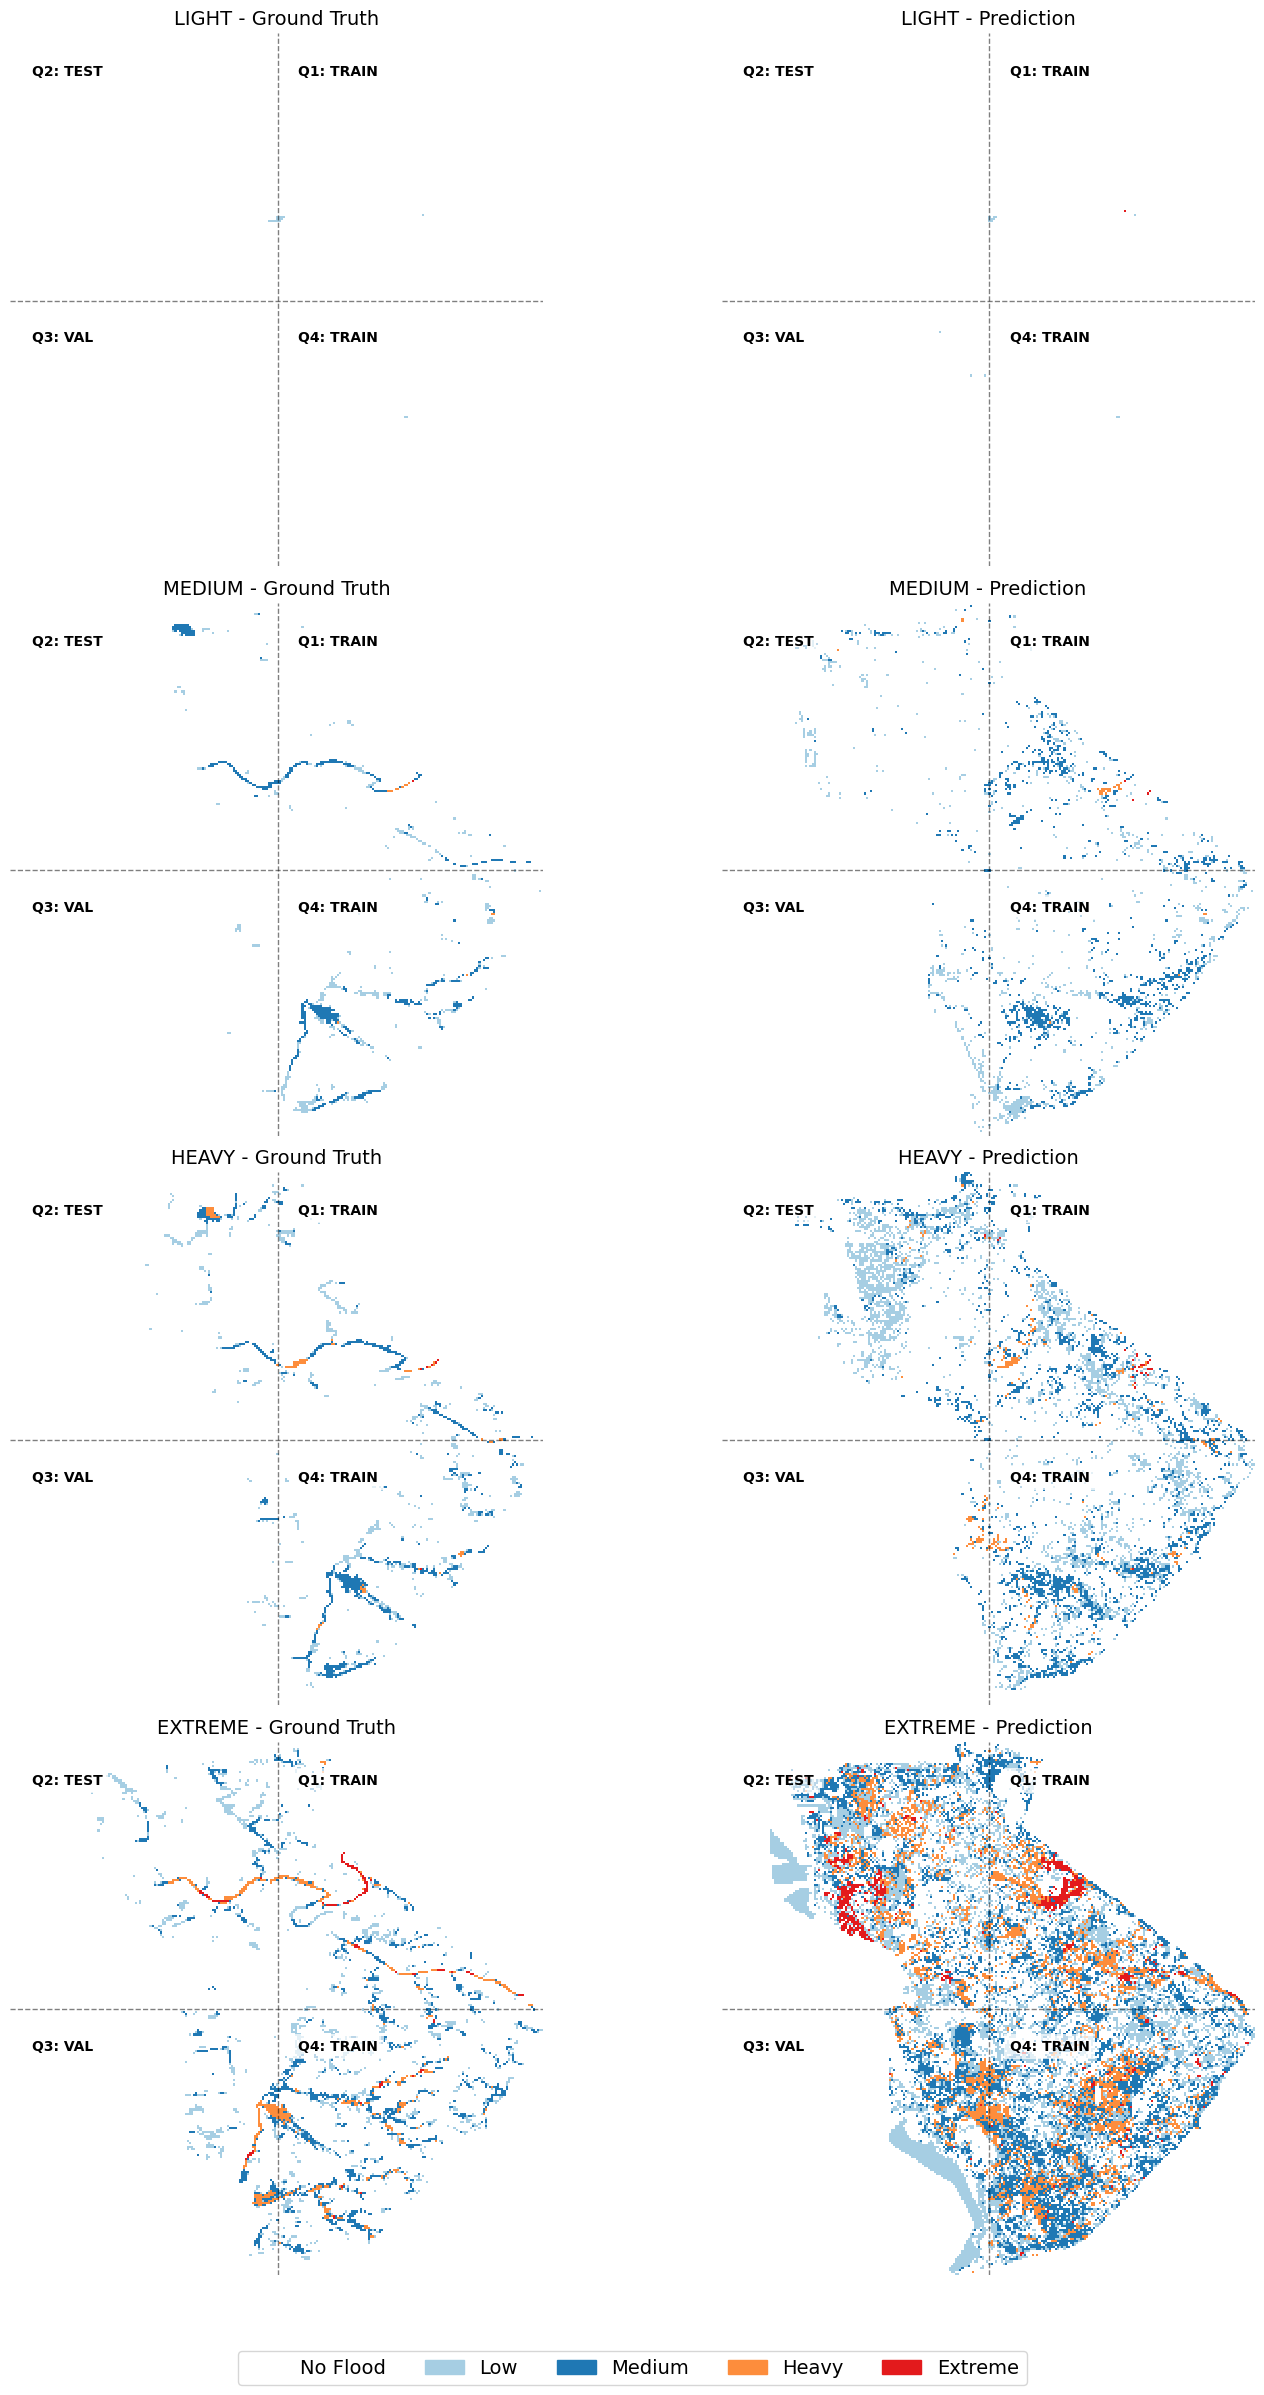


💾 Model Saved.


In [24]:
import numpy as np
import os
import rasterio
from rasterio.enums import Resampling
import gc
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.utils import resample, shuffle
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
import seaborn as sns

# ================= CONFIGURATION =================
# 1. PATHS
dem_npy_path     = "./processed_aux_map/processed_dem_numpy/dem_features.npy"
soil_npy_path    = "./processed_aux_map/processed_soil_numpy/soil_features.npy"
landuse_npy_path = "./processed_aux_map/processed_landuse_numpy/landuse_features.npy" # <--- ADDED

hyeto_dir        = "./processed_aux_map/hyetograph" 
flood_gt_dir     = "./processed_aux_map/ground_truth" 
manila_mask_path = "D:\\PC\\Documents\\SCHOOL\\GIT-THESIS\\XGBOOST-CONF\\manila_mask.tif"

# 2. SCENARIOS
scenario_map = {
    "LIGHT":   "L_Chicago_Water_Pixel.tif", 
    "MEDIUM":  "M_Chicago_Water_Pixel.tif", 
    "HEAVY":   "H_Chicago_Water_Pixel.tif",
    "EXTREME": "E_Chicago_Water_Pixel.tif"
}

H, W = 256, 256
num_pixels = H * W
# =================================================

print("🚀 STARTING SPATIAL PIPELINE (HYBRID SAMPLING + LAND USE)...\n")

# --- STEP 1: LOAD STATIC FEATURES ---
print("1️⃣ Loading Static Features (DEM + Soil + LandUse)...")

if not os.path.exists(landuse_npy_path):
    raise FileNotFoundError("❌ Land Use file missing! Run the Land Use processing script first.")

dem_data  = np.load(dem_npy_path)   # (3, H, W)
soil_data = np.load(soil_npy_path)  # (4, H, W)
lu_data   = np.load(landuse_npy_path) # (1, H, W) <--- NEW

# Stack: 3 (DEM) + 4 (Soil) + 1 (LandUse) = 8 Channels
static_cube = np.concatenate([dem_data, soil_data, lu_data], axis=0)
static_cube = np.transpose(static_cube, (1, 2, 0)) 
X_static_flat = static_cube.reshape(-1, 8)

print(f"   -> Static Features Shape: {X_static_flat.shape} (8 Features)")

del dem_data, soil_data, lu_data, static_cube
gc.collect()

# --- STEP 2: GENERATE QUADRANT MASK ---
print("2️⃣ Generating Spatial Quadrants...")
y_coords, x_coords = np.indices((H, W))
mid_y, mid_x = H // 2, W // 2

quadrant_map = np.zeros((H, W), dtype=int)
quadrant_map[(y_coords < mid_y) & (x_coords >= mid_x)] = 1 # Q1 (Train)
quadrant_map[(y_coords < mid_y) & (x_coords < mid_x)] = 2  # Q2 (Test)
quadrant_map[(y_coords >= mid_y) & (x_coords < mid_x)] = 3 # Q3 (Valid)
quadrant_map[(y_coords >= mid_y) & (x_coords >= mid_x)] = 4 # Q4 (Train)
quadrant_flat = quadrant_map.flatten()

# --- STEP 3: LOAD MANILA MASK ---
print(f"<mask> Loading Manila Mask from: {manila_mask_path}")
if not os.path.exists(manila_mask_path):
    raise FileNotFoundError("Mask file missing.")

with rasterio.open(manila_mask_path) as src:
    mask_arr = src.read(1, out_shape=(H, W), resampling=Resampling.nearest)
mask_flat = mask_arr.flatten()
is_in_manila = (mask_flat > 0)

# --- STEP 4: LOOP SCENARIOS AND SPLIT ---
X_train_list, y_train_list = [], []
X_val_list, y_val_list = [], []
X_test_list, y_test_list = [], []

print("\n3️⃣ Processing Scenarios & Splitting spatially...")

for sc_name, gt_filename in scenario_map.items():
    
    # Paths Logic
    hyeto_filename = f"{sc_name}_chicago.npy" 
    hyeto_path = os.path.join(hyeto_dir, hyeto_filename)
    gt_path = os.path.join(flood_gt_dir, gt_filename)

    if not os.path.exists(hyeto_path):
        print(f"   ⚠️ Skipping {sc_name}: Rain file missing.")
        continue
    if not os.path.exists(gt_path):
         gt_path = os.path.join(flood_gt_dir, os.path.basename(gt_filename))
    if not os.path.exists(gt_path): 
        print(f"   ⚠️ Skipping {sc_name}: GT file missing.")
        continue

    # Load Rain
    rain_array = np.load(hyeto_path)
    if rain_array.ndim > 1: rain_array = rain_array.flatten()

    # Create Feature Table (8 Static + 5 Rain = 13 Features)
    rain_flat = np.tile(rain_array, (num_pixels, 1))
    X_scenario = np.hstack([X_static_flat, rain_flat])
    
    # Load Labels
    with rasterio.open(gt_path) as src:
        flood_arr = src.read(1, out_shape=(H, W), resampling=Resampling.nearest)
    y_scenario = flood_arr.flatten()
    
    # Apply Mask (Inside Manila + Valid Data)
    valid_pixels = is_in_manila & (y_scenario != -1) & (y_scenario != 255)
    
    # Split into Train/Test/Val based on Quadrants
    train_mask = valid_pixels & ((quadrant_flat == 1) | (quadrant_flat == 4))
    test_mask = valid_pixels & (quadrant_flat == 2)
    val_mask = valid_pixels & (quadrant_flat == 3)
    
    X_train_list.append(X_scenario[train_mask])
    y_train_list.append(y_scenario[train_mask])
    
    X_test_list.append(X_scenario[test_mask])
    y_test_list.append(y_scenario[test_mask])
    
    X_val_list.append(X_scenario[val_mask])
    y_val_list.append(y_scenario[val_mask])
    
    print(f"   -> {sc_name}: Train={np.sum(train_mask)} | Val={np.sum(val_mask)} | Test={np.sum(test_mask)}")

# --- STEP 5: MERGE & CHECK ---
if len(X_train_list) == 0: raise ValueError("❌ No data loaded!")

X_train = np.vstack(X_train_list)
y_train = np.concatenate(y_train_list)
X_val = np.vstack(X_val_list)
y_val = np.concatenate(y_val_list)
X_test = np.vstack(X_test_list)
y_test = np.concatenate(y_test_list)

print(f"✅ Split Complete. Raw Train Size: {len(y_train)}")

# --- STEP 6: HYBRID SAMPLING (ROBIN HOOD METHOD) ---
print("\n⚖️ Applying Hybrid Sampling (Undersample Safe, Oversample Extreme)...")

# 1. Split data by Class
X_c0 = X_train[y_train == 0]
y_c0 = y_train[y_train == 0]
X_c1 = X_train[y_train == 1]
y_c1 = y_train[y_train == 1]
X_c2 = X_train[y_train == 2]
y_c2 = y_train[y_train == 2]
X_c3 = X_train[y_train == 3]
y_c3 = y_train[y_train == 3]
X_c4 = X_train[y_train == 4]
y_c4 = y_train[y_train == 4]

print(f"   Original Counts: 0:{len(y_c0)} | 1:{len(y_c1)} | 2:{len(y_c2)} | 3:{len(y_c3)} | 4:{len(y_c4)}")

# 2. DEFINE TARGET SIZE (Aim for ~Low Class size)
target_size = len(y_c1) 
if target_size < 1000: target_size = 1000

print(f"   -> Target per class: ~{target_size}")

# 3. RESAMPLE
# Class 0: Undersample (2x target)
X_c0_new, y_c0_new = resample(X_c0, y_c0, replace=False, n_samples=min(len(y_c0), target_size * 2), random_state=42)
# Class 1, 2: Match target
X_c1_new, y_c1_new = resample(X_c1, y_c1, replace=True, n_samples=target_size, random_state=42)
X_c2_new, y_c2_new = resample(X_c2, y_c2, replace=True, n_samples=target_size, random_state=42)
# Class 3, 4: Oversample (Duplicate)
X_c3_new, y_c3_new = resample(X_c3, y_c3, replace=True, n_samples=target_size, random_state=42)
X_c4_new, y_c4_new = resample(X_c4, y_c4, replace=True, n_samples=target_size, random_state=42)

# 4. COMBINE & SHUFFLE
X_train_bal = np.vstack([X_c0_new, X_c1_new, X_c2_new, X_c3_new, X_c4_new])
y_train_bal = np.concatenate([y_c0_new, y_c1_new, y_c2_new, y_c3_new, y_c4_new])
X_train_bal, y_train_bal = shuffle(X_train_bal, y_train_bal, random_state=42)

print(f"   -> Final Training Size: {len(y_train_bal)}")

print("\n🚀 Training XGBoost...")
model = XGBClassifier(
    n_estimators=1000,
    learning_rate=0.03,
    max_depth=8,
    min_child_weight=1,
    gamma=0.2,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='multi:softmax',
    num_class=5,
    n_jobs=-1,
    random_state=42,
    early_stopping_rounds=25 
)

model.fit(
    X_train_bal, 
    y_train_bal, 
    eval_set=[(X_val, y_val)], 
    verbose=True
)

# --- STEP 7: EVALUATION ---
print("\n📊 Evaluating on TEST Quadrant (Q2)...")
if len(y_test) > 0:
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"✅ Spatial Test Accuracy: {acc * 100:.2f}%")

    target_names = ["No Flood", "Low", "Medium", "Heavy", "Extreme"]
    unique_test = np.unique(y_test)
    names_present = [target_names[i] for i in unique_test if i < len(target_names)]

    print(classification_report(y_test, y_pred, target_names=names_present))

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=names_present, yticklabels=names_present)
    plt.title('Confusion Matrix (Spatial Test Q2)')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
else:
    print("⚠️ Skipping Evaluation (Test set empty)")

# --- STEP 8: VISUALIZATION (ALL SCENARIOS) ---
print("\n🗺️ Generating Comparison Maps for ALL Scenarios...")

scenarios_to_plot = ["LIGHT", "MEDIUM", "HEAVY", "EXTREME"]
flood_cmap = ListedColormap(['white', '#a6cee3', '#1f78b4', '#fd8d3c', '#e31a1c'])
classes = ['No Flood', 'Low', 'Medium', 'Heavy', 'Extreme']

fig, axes = plt.subplots(4, 2, figsize=(16, 24))

def draw_quadrants(ax):
    # Crosshair
    ax.axvline(x=mid_x, color='black', linestyle='--', linewidth=1, alpha=0.5)
    ax.axhline(y=mid_y, color='black', linestyle='--', linewidth=1, alpha=0.5)
    # Labels
    ax.text(10, 20, "Q2: TEST", fontsize=10, fontweight='bold', bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))
    ax.text(mid_x + 10, 20, "Q1: TRAIN", fontsize=10, fontweight='bold', bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))
    ax.text(10, mid_y + 20, "Q3: VAL", fontsize=10, fontweight='bold', bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))
    ax.text(mid_x + 10, mid_y + 20, "Q4: TRAIN", fontsize=10, fontweight='bold', bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))

for idx, sc_name in enumerate(scenarios_to_plot):
    print(f"   Processing {sc_name}...")
    
    # 1. Load Rain & GT
    hyeto_file = os.path.join(hyeto_dir, f"{sc_name}_chicago.npy")
    gt_file = scenario_map[sc_name]
    if not os.path.exists(gt_file): gt_file = os.path.join(flood_gt_dir, os.path.basename(gt_file))

    if not os.path.exists(hyeto_file) or not os.path.exists(gt_file):
        print(f"      ❌ Missing files for {sc_name}, skipping.")
        continue

    # Load Rain
    rain_vals = np.load(hyeto_file)
    if rain_vals.ndim > 1: rain_vals = rain_vals.flatten()
    rain_layer = np.tile(rain_vals, (num_pixels, 1))
    
    # Construct Features for this scenario (Static[8] + Rain[5])
    X_full = np.hstack([X_static_flat, rain_layer])

    # Load Ground Truth
    with rasterio.open(gt_file) as src:
        y_gt_full = src.read(1, out_shape=(H, W), resampling=Resampling.nearest).flatten()

    # 2. Filter & Predict
    valid_indices = is_in_manila & (y_gt_full != -1) & (y_gt_full != 255)
    
    if np.sum(valid_indices) > 0:
        X_to_predict = X_full[valid_indices]
        y_pred_vis = model.predict(X_to_predict)

        # 3. Reconstruct Maps
        flat_gt = np.full(num_pixels, np.nan)
        flat_pred = np.full(num_pixels, np.nan)

        flat_gt[valid_indices] = y_gt_full[valid_indices]
        flat_pred[valid_indices] = y_pred_vis

        map_gt = flat_gt.reshape(H, W)
        map_pred = flat_pred.reshape(H, W)

        # 4. Plot Ground Truth (Left Column)
        ax_gt = axes[idx, 0]
        ax_gt.imshow(map_gt, cmap=flood_cmap, vmin=0, vmax=4, interpolation='nearest')
        ax_gt.set_title(f"{sc_name} - Ground Truth", fontsize=14)
        draw_quadrants(ax_gt)
        ax_gt.axis('off')

        # 5. Plot Prediction (Right Column)
        ax_pred = axes[idx, 1]
        ax_pred.imshow(map_pred, cmap=flood_cmap, vmin=0, vmax=4, interpolation='nearest')
        ax_pred.set_title(f"{sc_name} - Prediction", fontsize=14)
        draw_quadrants(ax_pred)
        ax_pred.axis('off')
    else:
        print(f"      ⚠️ No valid pixels for {sc_name} inside mask.")

# --- LEGEND ---
colors = ['white', '#a6cee3', '#1f78b4', '#fd8d3c', '#e31a1c']
patches = [mpatches.Patch(color=colors[i], label=classes[i]) for i in range(len(classes))]
fig.legend(handles=patches, loc='lower center', ncol=5, fontsize=14, frameon=True)

plt.tight_layout()
plt.subplots_adjust(bottom=0.05) # Space for legend
plt.show()

model.save_model("xgboost_hybrid_landuse.json")
print("\n💾 Model Saved.")